In [6]:
import pandas as pd
import numpy as np
import os
import time
from sklearn.model_selection import train_test_split

In [7]:
combined_stocks_df = pd.read_csv("filtered_stocks_combined.csv")

In [8]:
combined_stocks_df

,Date,index,Open,High,Low,Close,Volume,OpenInt,ticker
0,2011-01-03,45725,41.600,42.293,41.600,42.204,123930383,0,AAPL
1,2011-01-04,45726,42.579,42.579,42.023,42.426,86135637,0,AAPL
2,2011-01-05,45727,42.260,42.817,42.196,42.772,70669988,0,AAPL
3,2011-01-06,45728,42.902,42.932,42.632,42.739,83619699,0,AAPL
4,2011-01-07,45729,42.787,43.073,42.503,43.045,86506108,0,AAPL
...,...,...,...,...,...,...,...,...,...
75495,2016-12-23,14745947,87.556,87.625,87.201,87.383,4428429,0,XOM
75496,2016-12-27,14745948,87.499,87.768,87.257,87.423,5100402,0,XOM
75497,2016-12-28,14745949,87.354,87.768,86.949,86.989,6834213,0,XOM
75498,2016-12-29,14745950,86.797,87.277,86.728,87.036,6938299,0,XOM


In [9]:
# Convert Date to datetime and set as index
combined_stocks_df["Date"] = pd.to_datetime(combined_stocks_df["Date"])
combined_stocks_df.set_index("Date", inplace=True)

# Drop unnecessary columns if any
combined_stocks_df = combined_stocks_df.drop(columns=["index"])  # Optional

# Pivot to multi-level columns: Ticker as level 1, feature as level 2
stocks_df = combined_stocks_df.pivot_table(
    index=combined_stocks_df.index,
    columns="ticker",
    values=[col for col in combined_stocks_df.columns if col != "ticker"]
)

# Sort columns for clarity
stocks_df = stocks_df.sort_index(axis=1, level=0)


# Swap the column MultiIndex levels
stocks_df_leveled = stocks_df.swaplevel(axis=1)

# Sort by ticker (Level 0)
stocks_df_leveled = stocks_df_leveled.sort_index(axis=1, level=0)

# Preview the new structure
stocks_df_leveled.head()


ticker        AAPL                                                  ABT  \
             Close    High     Low    Open OpenInt       Volume   Close   
Date                                                                      
2011-01-03  42.204  42.293  41.600  41.600     0.0  123930383.0  19.358   
2011-01-04  42.426  42.579  42.023  42.579     0.0   86135637.0  19.540   
2011-01-05  42.772  42.817  42.196  42.260     0.0   70669988.0  19.540   
2011-01-06  42.739  42.932  42.632  42.902     0.0   83619699.0  19.500   
2011-01-07  43.045  43.073  42.503  42.787     0.0   86506108.0  19.582   

ticker                              ...     WMT                              \
              High     Low    Open  ...     Low    Open OpenInt      Volume   
Date                                ...                                       
2011-01-03  19.549  19.338  19.549  ...  46.027  46.089     0.0  16789275.0   
2011-01-04  19.561  19.350  19.448  ...  46.139  46.419     0.0  14296931.0   
2011-01-05  19.764  19.460  19.520  ...  46.174  46.539     0.0  16723328.0   
2011-01-06  19.682  19.342  19.634  ...  45.712  46.166     0.0  18335156.0   
2011-01-07  19.615  19.444  19.489  ...  45.698  45.810     0.0   9374462.0   

ticker         XOM                                              
             Close    High     Low    Open OpenInt      Volume  
Date                                                            
2011-01-03  60.341  60.535  59.604  59.668     0.0  28807445.0  
2011-01-04  60.625  60.665  60.235  60.469     0.0  24744869.0  
2011-01-05  60.462  60.600  60.009  60.430     0.0  20448359.0  
2011-01-06  60.853  61.052  60.439  60.625     0.0  27829692.0  
2011-01-07  61.182  61.431  60.777  60.876     0.0  23838996.0  

[5 rows x 300 columns]

In [10]:
# 3. Time-based split into 60% train, 20% val, 20% test
train_dict, val_dict, test_dict = {}, {}, {}

for ticker in stocks_df_leveled.columns.levels[0]:
    stocks_df_leveled.loc[:, (ticker, 'log_return')] = np.log(
    stocks_df_leveled[ticker]['Close'] / stocks_df_leveled[ticker]['Close'].shift(1)
)

    df = stocks_df_leveled[ticker].dropna().sort_index()
    total_len = len(df)
    train_end = int(total_len * 0.6)
    val_end = train_end + int(total_len * 0.2)

    train_dict[ticker] = df.iloc[:train_end]
    val_dict[ticker] = df.iloc[train_end:val_end]
    test_dict[ticker] = df.iloc[val_end:]

train_df = pd.concat(train_dict, names=["Ticker", "Date"])
val_df = pd.concat(val_dict, names=["Ticker", "Date"])
test_df = pd.concat(test_dict, names=["Ticker", "Date"])


In [11]:
train_df

Close    High     Low    Open  OpenInt       Volume  \
Ticker Date                                                               
AAPL   2011-01-04  42.426  42.579  42.023  42.579      0.0   86135637.0   
       2011-01-05  42.772  42.817  42.196  42.260      0.0   70669988.0   
       2011-01-06  42.739  42.932  42.632  42.902      0.0   83619699.0   
       2011-01-07  43.045  43.073  42.503  42.787      0.0   86506108.0   
       2011-01-10  43.855  43.956  43.179  43.393      0.0  124888228.0   
...                   ...     ...     ...     ...      ...          ...   
XOM    2014-08-04  88.145  88.411  86.542  86.921      0.0   13804459.0   
       2014-08-05  86.445  87.625  86.077  87.492      0.0   14847864.0   
       2014-08-06  87.133  87.723  86.445  86.445      0.0   11264688.0   
       2014-08-07  86.507  87.889  85.944  87.828      0.0   11379351.0   
       2014-08-08  87.800  87.847  86.551  86.947      0.0   12730751.0   

                   log_return  
Ticker Date                    
AAPL   2011-01-04    0.005246  
       2011-01-05    0.008122  
       2011-01-06   -0.000772  
       2011-01-07    0.007134  
       2011-01-10    0.018643  
...                       ...  
XOM    2014-08-04    0.013374  
       2014-08-05   -0.019475  
       2014-08-06    0.007927  
       2014-08-07   -0.007210  
       2014-08-08    0.014836  

[45250 rows x 7 columns]

In [23]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from keras_tuner import RandomSearch

# Debug: Print MultiIndex structure
print("Column MultiIndex structure:")
print("Level 0:", stocks_df_leveled.columns.levels[0].tolist())
print("Level 1:", stocks_df_leveled.columns.levels[1].tolist())
print("Sample columns:", stocks_df_leveled.columns[:10].tolist())

# Determine ticker and feature levels
known_features = {'Close', 'Open', 'High', 'Low', 'Volume', 'OpenInt', 'close', 'open', 'high', 'low', 'volume', 'lag_1_close', 'lag_2_close', 'RSI', 'EMA_10', 'returns', 'volatility_5'}
known_tickers = {'AAPL', 'MSFT', 'GOOG', 'ABT', 'ADBE', 'AMD', 'AMGN', 'AMZN', 'AXP', 'BAC', 'BSX', 'C', 'CAT', 'CMCSA', 'COST', 'CSCO', 'CVX', 'DHR', 'DIS', 'GE', 'GOOGL', 'GS', 'HD', 'HON', 'IBM', 'INTU', 'JNJ', 'JPM', 'KO', 'LLY', 'MCD', 'MRK', 'NVDA', 'ORCL', 'PEP', 'PFE', 'PG', 'PGR', 'QCOM', 'SMFG', 'SPGI', 'SYK', 'T', 'TMO', 'TXN', 'UNH', 'UNP', 'VZ', 'WFC', 'WMT', 'XOM'}
if any(f in stocks_df_leveled.columns.levels[0] for f in known_features):
    ticker_level = 1
    feature_level = 0
    print("Detected: Features in level 0, tickers in level 1")
else:
    ticker_level = 0
    feature_level = 1
    print("Detected: Tickers in level 0, features in level 1")

# Drop 'OpenInt' if it exists
if 'OpenInt' in stocks_df_leveled.columns.levels[feature_level]:
    stocks_df_leveled = stocks_df_leveled.drop('OpenInt', level=feature_level, axis=1)
    print("'OpenInt' dropped successfully.")
else:
    print("'OpenInt' not found in columns. Proceeding without dropping.")

# Feature engineering
def add_features(df, ticker_level=0, feature_level=1):
    tickers = [t for t in df.columns.levels[ticker_level] if t not in known_features]
    print(f"Processing tickers: {tickers[:10]}... (total: {len(tickers)})")
    for ticker in tickers:
        if ticker not in known_tickers:
            print(f"Warning: Skipping unknown ticker {ticker}")
            continue
        # Validate 'Close' exists
        col = (ticker, 'Close') if ticker_level == 0 else ('Close', ticker)
        try:
            df[col]
        except KeyError:
            print(f"Warning: 'Close' not found for ticker {ticker}. Skipping.")
            continue
        # Lag Features
        df[(ticker, 'lag_1_close') if ticker_level == 0 else ('lag_1_close', ticker)] = df[col].shift(1)
        df[(ticker, 'lag_2_close') if ticker_level == 0 else ('lag_2_close', ticker)] = df[col].shift(2)
        
        # RSI (14-day)
        delta = df[col].diff()
        gain = (delta.where(delta > 0, 0)).rolling(window=14).mean()
        loss = (-delta.where(delta < 0, 0)).rolling(window=14).mean()
        rs = gain / (loss + 1e-10)
        df[(ticker, 'RSI') if ticker_level == 0 else ('RSI', ticker)] = 100 - (100 / (1 + rs))
        
        # EMA (10-day)
        df[(ticker, 'EMA_10') if ticker_level == 0 else ('EMA_10', ticker)] = df[col].ewm(span=10, adjust=False).mean()
        
        # Volatility (5-day)
        df[(ticker, 'returns') if ticker_level == 0 else ('returns', ticker)] = df[col].pct_change()
        df[(ticker, 'volatility_5') if ticker_level == 0 else ('volatility_5', ticker)] = df[(ticker, 'returns') if ticker_level == 0 else ('returns', ticker)].rolling(window=5).std()
    
    print("Feature engineering complete. Columns after:", df.columns.levels[feature_level].tolist())
    return df.dropna()

# Apply feature engineering
stocks_df_leveled = add_features(stocks_df_leveled, ticker_level=ticker_level, feature_level=feature_level)

# Time-based split: 60% train, 20% val, 20% test
total_len = len(stocks_df_leveled)
train_end = int(total_len * 0.6)
val_end = train_end + int(total_len * 0.2)

train_df = stocks_df_leveled.iloc[:train_end]
val_df = stocks_df_leveled.iloc[train_end:val_end]
test_df = stocks_df_leveled.iloc[val_end:]

# Rolling window data creation
def create_rolling_window_data(df, window_size=10, target_shift=1, ticker_level=0, feature_level=1):
    X, y, today_closes = [], [], []
    tickers = [t for t in df.columns.levels[ticker_level] if t not in known_features]
    num_tickers = len(tickers)
    features = ['Open', 'High', 'Low', 'Volume', 'lag_1_close', 'lag_2_close', 'RSI', 'EMA_10', 'volatility_5']
    print(f"Creating rolling windows for {num_tickers} tickers with features: {features}")
    
    # Select feature columns
    feature_cols = [col for col in df.columns if col[feature_level] in features]
    
    for i in range(window_size, len(df) - target_shift - 1):
        window = df[feature_cols].iloc[i - window_size:i]
        X.append(window.values.flatten())
        
        next_day = df.iloc[i + target_shift]
        today = df.iloc[i]
        targets = []
        closes = []
        for ticker in tickers:
            try:
                open_col = (ticker, 'Open') if ticker_level == 0 else ('Open', ticker)
                close_col = (ticker, 'Close') if ticker_level == 0 else ('Close', ticker)
                targets.append(next_day[open_col])
                targets.append(next_day[close_col])
                closes.append(today[close_col])
            except KeyError as e:
                print(f"Warning: Skipping ticker {ticker} due to missing column {e}.")
                continue
        if len(targets) == num_tickers * 2:
            y.append(targets)
            today_closes.append(closes)
    
    X, y, today_closes = np.array(X), np.array(y), np.array(today_closes)
    print(f"Created {len(X)} windows with {len(y)} targets")
    return X, y, today_closes, num_tickers

# Evaluate window sizes
def evaluate_window_size(df, window_size, ticker_level=0, feature_level=1):
    X, y, today_closes, num_tickers = create_rolling_window_data(
        df, window_size=window_size, ticker_level=ticker_level, feature_level=feature_level
    )
    
    if len(X) == 0 or len(y) == 0:
        print(f"Warning: No valid data for window_size={window_size}. Skipping.")
        return float('inf'), None, None, None, num_tickers, None, None, None, None, None, None, None
    
    total_size = len(X)
    train_size = int(0.6 * total_size)
    val_size = int(0.2 * total_size)
    
    X_train, y_train = X[:train_size], y[:train_size]
    X_val, y_val = X[train_size:train_size + val_size], y[train_size:train_size + val_size]
    X_test, y_test, today_closes_test = X[train_size + val_size:], y[train_size + val_size:], today_closes[train_size + val_size:]
    
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_val_scaled = scaler.transform(X_val)
    X_test_scaled = scaler.transform(X_test)
    
    model = Sequential([
        Dense(512, activation='relu', input_shape=(X_train_scaled.shape[1],)),
        Dense(256, activation='relu'),
        Dense(num_tickers * 2)
    ])
    model.compile(optimizer='adam', loss='mse')
    model.fit(X_train_scaled, y_train, validation_data=(X_val_scaled, y_val), 
              epochs=50, batch_size=32, verbose=0)
    
    y_val_pred = model.predict(X_val_scaled, verbose=0)
    val_mpe = np.mean((y_val - y_val_pred) / (y_val + 1e-10)) * 100
    return val_mpe, X, y, today_closes, num_tickers, X_train_scaled, X_val_scaled, X_test_scaled, y_train, y_val, y_test, today_closes_test

# Test window sizes
window_sizes = range(1, 11)  # Extend to range(1, 31) for full optimization
mpe_scores = {}
for window_size in window_sizes:
    val_mpe, X, y, today_closes, num_tickers, X_train_scaled, X_val_scaled, X_test_scaled, y_train, y_val, y_test, today_closes_test = evaluate_window_size(
        stocks_df_leveled, window_size, ticker_level=ticker_level, feature_level=feature_level
    )
    if np.isinf(val_mpe):
        continue
    mpe_scores[window_size] = val_mpe
    print(f"Window Size {window_size}: Validation MPE = {val_mpe:.4f}%")

if not mpe_scores:
    raise ValueError("No valid window sizes produced data. Check DataFrame structure and columns.")

best_window_size = min(mpe_scores, key=mpe_scores.get)
print(f"Best Window Size: {best_window_size} with Validation MPE: {mpe_scores[best_window_size]:.4f}%")

# Hyperparameter tuning
def build_model(hp):
    model = Sequential()
    model.add(Dense(hp.Int('units1', min_value=128, max_value=1024, step=128),
                    activation='relu', input_shape=(X_train_scaled.shape[1],)))
    model.add(Dense(hp.Int('units2', min_value=64, max_value=512, step=64), activation='relu'))
    model.add(Dense(num_tickers * 2))
    learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])
    model.compile(optimizer=Adam(learning_rate=learning_rate), loss='mse')
    return model

# Use best window size
val_mpe, X, y, today_closes, num_tickers, X_train_scaled, X_val_scaled, X_test_scaled, y_train, y_val, y_test, today_closes_test = evaluate_window_size(
    stocks_df_leveled, best_window_size, ticker_level=ticker_level, feature_level=feature_level
)

tuner = RandomSearch(
    build_model,
    objective='val_loss',
    max_trials=5,
    executions_per_trial=1,
    directory='tuning_results',
    project_name='mlp_stock_tuning'
)
tuner.search(X_train_scaled, y_train,
             validation_data=(X_val_scaled, y_val),
             epochs=50,
             batch_size=32,
             verbose=1)

best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
best_model = tuner.get_best_models(num_models=1)[0]
print(f"Best Hyperparameters: {best_hps.values}")

# Evaluate
y_pred = best_model.predict(X_test_scaled)
mpe = np.mean((y_test - y_pred) / (y_test + 1e-10)) * 100
print(f"Test Mean Percentage Error (MPE): {mpe:.4f}%")

# Directional Accuracy
actual_close = y_test[:, 1::2]
predicted_close = y_pred[:, 1::2]
last_close = today_closes_test
actual_change = actual_close - last_close
predicted_change = predicted_close - last_close
directional_accuracy = np.mean(np.sign(actual_change) == np.sign(predicted_change))
print(f"Directional Accuracy for Close Prices: {directional_accuracy:.4f}")

Trial 5 Complete [00h 00m 04s]
val_loss: 2334.70947265625

Best val_loss So Far: 2328.3623046875
Total elapsed time: 00h 00m 23s
Best Hyperparameters: {'units1': 256, 'units2': 384, 'learning_rate': 0.001}
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Test Mean Percentage Error (MPE): -30.2410%
Directional Accuracy for Close Prices: 0.5097


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 14 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [26]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from keras_tuner import RandomSearch
from tensorflow.keras.layers import Input

# Debug: Print MultiIndex structure
print("Column MultiIndex structure:")
print("Level 0:", stocks_df_leveled.columns.levels[0].tolist())
print("Level 1:", stocks_df_leveled.columns.levels[1].tolist())
print("Sample columns:", stocks_df_leveled.columns[:10].tolist())

# Confirm (feature, ticker) order
known_features = {'Close', 'Open', 'High', 'Low', 'Volume', 'OpenInt', 'close', 'open', 'high', 'low', 'volume', 'lag_1_close', 'lag_2_close', 'RSI', 'EMA_10', 'returns', 'volatility_5'}
known_tickers = {'AAPL', 'MSFT', 'GOOG', 'ABT', 'ADBE', 'AMD', 'AMGN', 'AMZN', 'AXP', 'BAC', 'BSX', 'C', 'CAT', 'CMCSA', 'COST', 'CSCO', 'CVX', 'DHR', 'DIS', 'GE', 'GOOGL', 'GS', 'HD', 'HON', 'IBM', 'INTU', 'JNJ', 'JPM', 'KO', 'LLY', 'MCD', 'MRK', 'NVDA', 'ORCL', 'PEP', 'PFE', 'PG', 'PGR', 'QCOM', 'SMFG', 'SPGI', 'SYK', 'T', 'TMO', 'TXN', 'UNH', 'UNP', 'VZ', 'WFC', 'WMT', 'XOM'}
if any(f in stocks_df_leveled.columns.levels[0] for f in known_features):
    ticker_level = 1
    feature_level = 0
    print("Detected: Features in level 0, tickers in level 1")
else:
    ticker_level = 0
    feature_level = 1
    print("Detected: Tickers in level 0, features in level 1")

# Drop 'OpenInt' if it exists
if 'OpenInt' in stocks_df_leveled.columns.levels[feature_level]:
    stocks_df_leveled = stocks_df_leveled.drop('OpenInt', level=feature_level, axis=1)
    print("'OpenInt' dropped successfully.")
else:
    print("'OpenInt' not found in columns. Proceeding without dropping.")

# Feature engineering
def add_features(df, ticker_level=0, feature_level=1):
    tickers = [t for t in df.columns.levels[ticker_level] if t not in known_features]
    print(f"Processing tickers: {tickers[:10]}... (total: {len(tickers)})")
    for ticker in tickers:
        if ticker not in known_tickers:
            print(f"Warning: Skipping unknown ticker {ticker}")
            continue
        col = (ticker, 'Close') if ticker_level == 0 else ('Close', ticker)
        try:
            df[col]
        except KeyError:
            print(f"Warning: 'Close' not found for ticker {ticker}. Skipping.")
            continue
        df[(ticker, 'lag_1_close') if ticker_level == 0 else ('lag_1_close', ticker)] = df[col].shift(1)
        df[(ticker, 'lag_2_close') if ticker_level == 0 else ('lag_2_close', ticker)] = df[col].shift(2)
        delta = df[col].diff()
        gain = (delta.where(delta > 0, 0)).rolling(window=14).mean()
        loss = (-delta.where(delta < 0, 0)).rolling(window=14).mean()
        rs = gain / (loss + 1e-10)
        df[(ticker, 'RSI') if ticker_level == 0 else ('RSI', ticker)] = 100 - (100 / (1 + rs))
        df[(ticker, 'EMA_10') if ticker_level == 0 else ('EMA_10', ticker)] = df[col].ewm(span=10, adjust=False).mean()
        df[(ticker, 'returns') if ticker_level == 0 else ('returns', ticker)] = df[col].pct_change()
        df[(ticker, 'volatility_5') if ticker_level == 0 else ('volatility_5', ticker)] = df[(ticker, 'returns') if ticker_level == 0 else ('returns', ticker)].rolling(window=5).std()
    
    print("Feature engineering complete. Columns after:", df.columns.levels[feature_level].tolist())
    return df.dropna()

# Apply feature engineering
stocks_df_leveled = add_features(stocks_df_leveled, ticker_level=ticker_level, feature_level=feature_level)

# Time-based split: 60% train, 20% val, 20% test
total_len = len(stocks_df_leveled)
train_end = int(total_len * 0.6)
val_end = train_end + int(total_len * 0.2)

train_df = stocks_df_leveled.iloc[:train_end]
val_df = stocks_df_leveled.iloc[train_end:val_end]
test_df = stocks_df_leveled.iloc[val_end:]

# Rolling window data creation
def create_rolling_window_data(df, window_size=10, target_shift=1, ticker_level=0, feature_level=1, max_window_size=20):
    X, y, today_closes = [], [], []
    tickers = [t for t in df.columns.levels[ticker_level] if t not in known_features]
    num_tickers = len(tickers)
    features = ['Open', 'High', 'Low', 'Volume', 'lag_1_close', 'lag_2_close', 'RSI', 'EMA_10', 'volatility_5']
    print(f"Creating rolling windows for {num_tickers} tickers with features: {features}")
    
    feature_cols = [col for col in df.columns if col[feature_level] in features]
    
    # Start at max_window_size to align samples across window sizes
    for i in range(max_window_size, len(df) - target_shift - 1):
        # Use window_size for features, but align indices
        start_idx = i - window_size
        if start_idx < 0:
            continue
        window = df[feature_cols].iloc[start_idx:i]
        X.append(window.values.flatten())
        
        next_day = df.iloc[i + target_shift]
        today = df.iloc[i]
        targets = []
        closes = []
        for ticker in tickers:
            try:
                open_col = (ticker, 'Open') if ticker_level == 0 else ('Open', ticker)
                close_col = (ticker, 'Close') if ticker_level == 0 else ('Close', ticker)
                targets.append(next_day[open_col])
                targets.append(next_day[close_col])
                closes.append(today[close_col])
            except KeyError as e:
                print(f"Warning: Skipping ticker {ticker} due to missing column {e}.")
                continue
        if len(targets) == num_tickers * 2:
            y.append(targets)
            today_closes.append(closes)
    
    X, y, today_closes = np.array(X), np.array(y), np.array(today_closes)
    print(f"Created {len(X)} windows with {len(y)} targets for window_size={window_size}")
    return X, y, today_closes, num_tickers

# Train and evaluate model
def train_model(X_train_scaled, y_train, X_val_scaled, y_val, num_tickers):
    model = Sequential([
        Input(shape=(X_train_scaled.shape[1],)), # Use Input layer
        Dense(512, activation='relu'),
        Dense(256, activation='relu'),
        Dense(num_tickers * 2)
    ])
    model.compile(optimizer='adam', loss='mse')
    model.fit(X_train_scaled, y_train, validation_data=(X_val_scaled, y_val), 
              epochs=50, batch_size=32, verbose=0)
    return model

# Evaluate window sizes
def evaluate_window_size(df, window_size, ticker_level=0, feature_level=1, max_window_size=20):
    X, y, today_closes, num_tickers = create_rolling_window_data(
        df, window_size=window_size, ticker_level=ticker_level, feature_level=feature_level, max_window_size=max_window_size
    )
    
    if len(X) == 0 or len(y) == 0:
        print(f"Warning: No valid data for window_size={window_size}. Skipping.")
        return float('inf'), None, None, None, num_tickers, None, None, None, None, None, None, None, None
    
    total_size = len(X)
    train_size = int(0.6 * total_size)
    val_size = int(0.2 * total_size)
    
    X_train, y_train = X[:train_size], y[:train_size]
    X_val, y_val = X[train_size:train_size + val_size], y[train_size:train_size + val_size]
    X_test, y_test, today_closes_test = X[train_size + val_size:], y[train_size + val_size:], today_closes[train_size + val_size:]
    
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_val_scaled = scaler.transform(X_val)
    X_test_scaled = scaler.transform(X_test)
    
    model = train_model(X_train_scaled, y_train, X_val_scaled, y_val, num_tickers)
    
    y_val_pred = model.predict(X_val_scaled, verbose=0)
    val_mpe = np.mean((y_val - y_val_pred) / (y_val + 1e-10)) * 100
    y_test_pred = model.predict(X_test_scaled, verbose=0)
    
    return val_mpe, model, X, y, today_closes, num_tickers, X_train_scaled, X_val_scaled, X_test_scaled, y_train, y_val, y_test, y_test_pred, today_closes_test

# Varying Window Method: Train models for multiple window sizes
window_sizes = [1, 5, 10, 20]
max_window_size = max(window_sizes)  # For alignment
models = {}
predictions = {}
mpe_scores = {}
y_test_common = None
today_closes_test_common = None
for window_size in window_sizes:
    val_mpe, model, X, y, today_closes, num_tickers, X_train_scaled, X_val_scaled, X_test_scaled, y_train, y_val, y_test, y_test_pred, today_closes_test = evaluate_window_size(
        stocks_df_leveled, window_size, ticker_level=ticker_level, feature_level=feature_level, max_window_size=max_window_size
    )
    if np.isinf(val_mpe):
        continue
    models[window_size] = model
    predictions[window_size] = y_test_pred
    mpe_scores[window_size] = val_mpe
    print(f"Window Size {window_size}: Validation MPE = {val_mpe:.4f}%, Test Prediction Shape = {y_test_pred.shape}")
    if y_test_common is None:
        y_test_common = y_test
        today_closes_test_common = today_closes_test

if not mpe_scores:
    raise ValueError("No valid window sizes produced data. Check DataFrame structure and columns.")

# Verify prediction shapes
for ws, pred in predictions.items():
    print(f"Window Size {ws}: Prediction Shape = {pred.shape}")

# Compute weights based on inverse MPE
weights = {ws: 1 / max(abs(mpe), 0.01) for ws, mpe in mpe_scores.items()}
total_weight = sum(weights.values())
weights = {ws: w / total_weight for ws, w in weights.items()}
print("Ensemble weights:", {ws: f"{w:.4f}" for ws, w in weights.items()})

# Combine predictions
ensemble_pred = np.zeros_like(predictions[window_sizes[0]])
for window_size, pred in predictions.items():
    ensemble_pred += weights[window_size] * pred

# Evaluate ensemble
mpe = np.mean((y_test_common - ensemble_pred) / (y_test_common + 1e-10)) * 100
print(f"Varying Window Method Ensemble Test Mean Percentage Error (MPE): {mpe:.4f}%")

# Directional Accuracy
actual_close = y_test_common[:, 1::2]
predicted_close = ensemble_pred[:, 1::2]
last_close = today_closes_test_common
actual_change = actual_close - last_close
predicted_change = predicted_close - last_close
directional_accuracy = np.mean(np.sign(actual_change) == np.sign(predicted_change))
print(f"Varying Window Method Ensemble Directional Accuracy for Close Prices: {directional_accuracy:.4f}")

# Hyperparameter tuning on best single model
best_window_size = min(mpe_scores, key=mpe_scores.get)
print(f"Best Single Window Size: {best_window_size} with Validation MPE: {mpe_scores[best_window_size]:.4f}%")

def build_model(hp):
    model = Sequential()
    model.add(Input(shape=(X_train_scaled.shape[1],)))
    model.add(Dense(hp.Int('units1', min_value=128, max_value=1024, step=128),
                    activation='relu'))
    model.add(Dense(hp.Int('units2', min_value=64, max_value=512, step=64), activation='relu'))
    model.add(Dense(num_tickers * 2))
    learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])
    model.compile(optimizer=Adam(learning_rate=learning_rate), loss='mse')
    return model

val_mpe, model, X, y, today_closes, num_tickers, X_train_scaled, X_val_scaled, X_test_scaled, y_train, y_val, y_test, y_test_pred, today_closes_test = evaluate_window_size(
    stocks_df_leveled, best_window_size, ticker_level=ticker_level, feature_level=feature_level, max_window_size=max_window_size
)

tuner = RandomSearch(
    build_model,
    objective='val_loss',
    max_trials=5,
    executions_per_trial=1,
    directory='tuning_results',
    project_name='mlp_stock_tuning'
)
tuner.search(X_train_scaled, y_train,
             validation_data=(X_val_scaled, y_val),
             epochs=50,
             batch_size=32,
             verbose=1)

best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
best_model = tuner.get_best_models(num_models=1)[0]
print(f"Best Hyperparameters for Single Model: {best_hps.values}")

y_pred_single = best_model.predict(X_test_scaled)
mpe_single = np.mean((y_test - y_pred_single) / (y_test + 1e-10)) * 100
print(f"Single Model Test Mean Percentage Error (MPE): {mpe_single:.4f}%")

predicted_close_single = y_pred_single[:, 1::2]
predicted_change_single = predicted_close_single - last_close
directional_accuracy_single = np.mean(np.sign(actual_change) == np.sign(predicted_change_single))
print(f"Single Model Directional Accuracy for Close Prices: {directional_accuracy_single:.4f}")

Column MultiIndex structure:
Level 0: ['Close', 'High', 'Low', 'Open', 'OpenInt', 'Volume', 'lag_1_close', 'lag_2_close', 'RSI', 'EMA_10', 'returns', 'volatility_5']
Level 1: ['AAPL', 'ABT', 'ADBE', 'AMD', 'AMGN', 'AMZN', 'AXP', 'BAC', 'BSX', 'C', 'CAT', 'CMCSA', 'COST', 'CSCO', 'CVX', 'DHR', 'DIS', 'GE', 'GOOGL', 'GS', 'HD', 'HON', 'IBM', 'INTU', 'JNJ', 'JPM', 'KO', 'LLY', 'MCD', 'MRK', 'MSFT', 'NVDA', 'ORCL', 'PEP', 'PFE', 'PG', 'PGR', 'QCOM', 'SMFG', 'SPGI', 'SYK', 'T', 'TMO', 'TXN', 'UNH', 'UNP', 'VZ', 'WFC', 'WMT', 'XOM']
Sample columns: [('Close', 'AAPL'), ('Close', 'ABT'), ('Close', 'ADBE'), ('Close', 'AMD'), ('Close', 'AMGN'), ('Close', 'AMZN'), ('Close', 'AXP'), ('Close', 'BAC'), ('Close', 'BSX'), ('Close', 'C')]
Detected: Features in level 0, tickers in level 1
'OpenInt' dropped successfully.
Processing tickers: ['AAPL', 'ABT', 'ADBE', 'AMD', 'AMGN', 'AMZN', 'AXP', 'BAC', 'BSX', 'C']... (total: 50)
Feature engineering complete. Columns after: ['Close', 'High', 'Low', 'Open', 

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 14 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.optimizers import Adam
from sklearn.cluster import KMeans

# Debug: Print MultiIndex structure
print("Column MultiIndex structure:")
print("Level 0:", stocks_df_leveled.columns.levels[0].tolist())
print("Level 1:", stocks_df_leveled.columns.levels[1].tolist())
print("Sample columns:", stocks_df_leveled.columns[:10].tolist())

# Confirm (feature, ticker) order
known_features = {'Close', 'Open', 'High', 'Low', 'Volume', 'OpenInt', 'close', 'open', 'high', 'low', 'volume', 'lag_1_close', 'lag_2_close', 'RSI', 'EMA_10', 'returns', 'volatility_5'}
known_tickers = {'AAPL', 'MSFT', 'GOOG', 'ABT', 'ADBE', 'AMD', 'AMGN', 'AMZN', 'AXP', 'BAC', 'BSX', 'C', 'CAT', 'CMCSA', 'COST', 'CSCO', 'CVX', 'DHR', 'DIS', 'GE', 'GOOGL', 'GS', 'HD', 'HON', 'IBM', 'INTU', 'JNJ', 'JPM', 'KO', 'LLY', 'MCD', 'MRK', 'NVDA', 'ORCL', 'PEP', 'PFE', 'PG', 'PGR', 'QCOM', 'SMFG', 'SPGI', 'SYK', 'T', 'TMO', 'TXN', 'UNH', 'UNP', 'VZ', 'WFC', 'WMT', 'XOM'}
if any(f in stocks_df_leveled.columns.levels[0] for f in known_features):
    ticker_level = 1
    feature_level = 0
    print("Detected: Features in level 0, tickers in level 1")
else:
    ticker_level = 0
    feature_level = 1
    print("Detected: Tickers in level 0, features in level 1")

# Drop 'OpenInt' if it exists
if 'OpenInt' in stocks_df_leveled.columns.levels[feature_level]:
    stocks_df_leveled = stocks_df_leveled.drop('OpenInt', level=feature_level, axis=1)
    print("'OpenInt' dropped successfully.")
else:
    print("'OpenInt' not found in columns. Proceeding without dropping.")

# Feature engineering
def add_features(df, ticker_level=0, feature_level=1):
    tickers = [t for t in df.columns.levels[ticker_level] if t not in known_features]
    print(f"Processing tickers: {tickers[:10]}... (total: {len(tickers)})")
    for ticker in tickers:
        if ticker not in known_tickers:
            print(f"Warning: Skipping unknown ticker {ticker}")
            continue
        col = (ticker, 'Close') if ticker_level == 0 else ('Close', ticker)
        try:
            df[col]
        except KeyError:
            print(f"Warning: 'Close' not found for ticker {ticker}. Skipping.")
            continue
        df[(ticker, 'lag_1_close') if ticker_level == 0 else ('lag_1_close', ticker)] = df[col].shift(1)
        df[(ticker, 'lag_2_close') if ticker_level == 0 else ('lag_2_close', ticker)] = df[col].shift(2)
        delta = df[col].diff()
        gain = (delta.where(delta > 0, 0)).rolling(window=14).mean()
        loss = (-delta.where(delta < 0, 0)).rolling(window=14).mean()
        rs = gain / (loss + 1e-10)
        df[(ticker, 'RSI') if ticker_level == 0 else ('RSI', ticker)] = 100 - (100 / (1 + rs))
        df[(ticker, 'EMA_10') if ticker_level == 0 else ('EMA_10', ticker)] = df[col].ewm(span=10, adjust=False).mean()
        df[(ticker, 'returns') if ticker_level == 0 else ('returns', ticker)] = df[col].pct_change()
        df[(ticker, 'volatility_5') if ticker_level == 0 else ('volatility_5', ticker)] = df[(ticker, 'returns') if ticker_level == 0 else ('returns', ticker)].rolling(window=5).std()
    
    print("Feature engineering complete. Columns after:", df.columns.levels[feature_level].tolist())
    return df.dropna()

# Apply feature engineering
stocks_df_leveled = add_features(stocks_df_leveled, ticker_level=ticker_level, feature_level=feature_level)

# Correlation-Based Clustering
print("\n--- Correlation-Based Clustering ---")
tickers_for_clustering = [t for t in stocks_df_leveled.columns.levels[ticker_level] if t not in known_features]

# Select 'returns' columns
if feature_level == 0:  # Features level 0, tickers level 1
    returns_df = stocks_df_leveled.loc[:, pd.IndexSlice['returns', tickers_for_clustering]]
    returns_df.columns = returns_df.columns.droplevel(0)  # Drop 'returns'
else:  # Tickers level 0, features level 1
    returns_df = stocks_df_leveled.loc[:, pd.IndexSlice[tickers_for_clustering, 'returns']]
    returns_df.columns = returns_df.columns.droplevel(1)  # Drop 'returns'

# Calculate correlation matrix
correlation_matrix = returns_df.corr().fillna(0)

# K-Means clustering
n_clusters = 5  # Adjustable based on needs
kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
cluster_labels = kmeans.fit_predict(correlation_matrix)

# Create groups
ticker_groups = {ticker: label for ticker, label in zip(tickers_for_clustering, cluster_labels)}
groups = {i: [] for i in range(n_clusters)}
for ticker, group_id in ticker_groups.items():
    groups[group_id].append(ticker)

print("Ticker Groups:")
for group_id, tickers_in_group in groups.items():
    print(f"  Group {group_id}: {tickers_in_group[:5]}... (Total: {len(tickers_in_group)})")

# Time-based split
total_len = len(stocks_df_leveled)
train_end = int(total_len * 0.6)
val_end = train_end + int(total_len * 0.2)

train_df = stocks_df_leveled.iloc[:train_end]
val_df = stocks_df_leveled.iloc[train_end:val_end]
test_df = stocks_df_leveled.iloc[val_end:]

# Rolling window data creation with ticker subset support
def create_rolling_window_data(df, window_size=10, target_shift=1, ticker_level=0, feature_level=1, max_window_size=20, tickers_to_use=None):
    X, y, today_closes = [], [], []
    if tickers_to_use is None:
        tickers = [t for t in df.columns.levels[ticker_level] if t not in known_features]
    else:
        tickers = tickers_to_use
    num_tickers = len(tickers)
    features = ['Open', 'High', 'Low', 'Volume', 'lag_1_close', 'lag_2_close', 'RSI', 'EMA_10', 'volatility_5']
    print(f"Creating rolling windows for {num_tickers} tickers with features: {features}")
    
    feature_cols = [col for col in df.columns if col[feature_level] in features and col[ticker_level] in tickers]
    
    for i in range(max_window_size, len(df) - target_shift - 1):
        start_idx = i - window_size
        if start_idx < 0:
            continue
        window = df[feature_cols].iloc[start_idx:i]
        X.append(window.values.flatten())
        
        next_day = df.iloc[i + target_shift]
        today = df.iloc[i]
        targets = []
        closes = []
        for ticker in tickers:
            try:
                open_col = (ticker, 'Open') if ticker_level == 0 else ('Open', ticker)
                close_col = (ticker, 'Close') if ticker_level == 0 else ('Close', ticker)
                targets.append(next_day[open_col])
                targets.append(next_day[close_col])
                closes.append(today[close_col])
            except KeyError as e:
                print(f"Warning: Skipping ticker {ticker} due to missing column {e}.")
                continue
        if len(targets) == num_tickers * 2:
            y.append(targets)
            today_closes.append(closes)
    
    X, y, today_closes = np.array(X), np.array(y), np.array(today_closes)
    print(f"Created {len(X)} windows with {len(y)} targets for window_size={window_size}")
    return X, y, today_closes, num_tickers

# Train model
def train_model(X_train_scaled, y_train, X_val_scaled, y_val, num_tickers):
    model = Sequential([
        Input(shape=(X_train_scaled.shape[1],)),
        Dense(512, activation='relu'),
        Dense(256, activation='relu'),
        Dense(num_tickers * 2)
    ])
    model.compile(optimizer='adam', loss='mse')
    model.fit(X_train_scaled, y_train, validation_data=(X_val_scaled, y_val), 
              epochs=50, batch_size=32, verbose=0)
    return model

# Evaluate window sizes
def evaluate_window_size(df, window_size, ticker_level=0, feature_level=1, max_window_size=20, tickers_to_use=None):
    X, y, today_closes, num_tickers = create_rolling_window_data(
        df, window_size=window_size, ticker_level=ticker_level, feature_level=feature_level, 
        max_window_size=max_window_size, tickers_to_use=tickers_to_use
    )
    
    if len(X) == 0 or len(y) == 0:
        print(f"Warning: No valid data for window_size={window_size}. Skipping.")
        return float('inf'), None, None, None, num_tickers, None, None, None, None, None, None, None, None
    
    total_size = len(X)
    train_size = int(0.6 * total_size)
    val_size = int(0.2 * total_size)
    
    X_train, y_train = X[:train_size], y[:train_size]
    X_val, y_val = X[train_size:train_size + val_size], y[train_size:train_size + val_size]
    X_test, y_test, today_closes_test = X[train_size + val_size:], y[train_size + val_size:], today_closes[train_size + val_size:]
    
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_val_scaled = scaler.transform(X_val)
    X_test_scaled = scaler.transform(X_test)
    
    model = train_model(X_train_scaled, y_train, X_val_scaled, y_val, num_tickers)
    
    y_val_pred = model.predict(X_val_scaled, verbose=0)
    val_mpe = np.mean((y_val - y_val_pred) / (y_val + 1e-10)) * 100
    y_test_pred = model.predict(X_test_scaled, verbose=0)
    
    return val_mpe, model, X, y, today_closes, num_tickers, X_train_scaled, X_val_scaled, X_test_scaled, y_train, y_val, y_test, y_test_pred, today_closes_test

# Group-Specific Optimal Window Ensemble
print("\n--- Group-Specific Optimal Window Ensemble ---")
window_range = range(1, 31)
top_n_windows = 5
all_group_predictions = {}
all_group_y_test = {}
all_group_today_closes = {}
group_final_mpe = {}
group_final_da = {}
all_tickers_ordered = [t for t in stocks_df_leveled.columns.levels[ticker_level] if t not in known_features]
ticker_to_index_map = {ticker: i for i, ticker in enumerate(all_tickers_ordered)}

for group_id, group_tickers in groups.items():
    print(f"\nProcessing Group {group_id} ({len(group_tickers)} tickers)...")
    if not group_tickers:
        print("Skipping empty group.")
        continue

    group_mpe_scores = {}
    group_models = {}
    group_predictions_test = {}
    group_y_test_data = None
    group_today_closes_test_data = None

    for window_size in window_range:
        val_mpe, model, X, y, today_closes, num_tickers, X_train_scaled, X_val_scaled, X_test_scaled, y_train, y_val, y_test, y_test_pred, today_closes_test = evaluate_window_size(
            stocks_df_leveled, window_size, ticker_level=ticker_level, feature_level=feature_level, 
            max_window_size=max(window_range), tickers_to_use=group_tickers
        )
        if np.isinf(val_mpe):
            continue
        group_mpe_scores[window_size] = val_mpe
        group_models[window_size] = model
        group_predictions_test[window_size] = y_test_pred
        if group_y_test_data is None:
            group_y_test_data = y_test
            group_today_closes_test_data = today_closes_test

    if not group_mpe_scores:
        print(f"Warning: No valid window sizes for Group {group_id}.")
        continue

    # Select top N windows
    sorted_windows = sorted(group_mpe_scores.items(), key=lambda item: abs(item[1]))
    best_n_windows = dict(sorted_windows[:top_n_windows])

    # Create ensemble
    group_weights = {ws: 1 / max(abs(mpe), 0.01) for ws, mpe in best_n_windows.items()}
    group_total_weight = sum(group_weights.values())
    group_weights = {ws: w / group_total_weight for ws, w in group_weights.items()}

    group_ensemble_pred = np.zeros_like(group_predictions_test[list(best_n_windows.keys())[0]])
    for window_size, weight in group_weights.items():
        group_ensemble_pred += weight * group_predictions_test[window_size]

    all_group_predictions[group_id] = group_ensemble_pred
    all_group_y_test[group_id] = group_y_test_data
    all_group_today_closes[group_id] = group_today_closes_test_data

    # Evaluate group ensemble
    group_mpe = np.mean((group_y_test_data - group_ensemble_pred) / (group_y_test_data + 1e-10)) * 100
    group_actual_close = group_y_test_data[:, 1::2]
    group_predicted_close = group_ensemble_pred[:, 1::2]
    group_last_close = group_today_closes_test_data
    group_actual_change = group_actual_close - group_last_close
    group_predicted_change = group_predicted_close - group_last_close
    group_da = np.mean(np.sign(group_actual_change) == np.sign(group_predicted_change))
    group_final_mpe[group_id] = group_mpe
    group_final_da[group_id] = group_da
    print(f"  Group {group_id} Ensemble: Test MPE = {group_mpe:.4f}%, DA = {group_da:.4f}")

# Combine Group Predictions
num_test_samples = list(all_group_predictions.values())[0].shape[0]
num_total_tickers = len(all_tickers_ordered)
final_ensemble_pred = np.zeros((num_test_samples, num_total_tickers * 2))
final_y_test = np.zeros((num_test_samples, num_total_tickers * 2))
final_today_closes = np.zeros((num_test_samples, num_total_tickers))

for group_id, group_tickers in groups.items():
    if group_id not in all_group_predictions:
        continue
    group_pred = all_group_predictions[group_id]
    group_y = all_group_y_test[group_id]
    group_closes = all_group_today_closes[group_id]
    for i, ticker in enumerate(group_tickers):
        original_idx = ticker_to_index_map[ticker]
        final_ensemble_pred[:, original_idx * 2] = group_pred[:, i * 2]
        final_ensemble_pred[:, original_idx * 2 + 1] = group_pred[:, i * 2 + 1]
        final_y_test[:, original_idx * 2] = group_y[:, i * 2]
        final_y_test[:, original_idx * 2 + 1] = group_y[:, i * 2 + 1]
        final_today_closes[:, original_idx] = group_closes[:, i]

# Evaluate Final Ensemble
final_mpe = np.mean((final_y_test - final_ensemble_pred) / (final_y_test + 1e-10)) * 100
print(f"Group-Based Ensemble Overall Test Mean Percentage Error (MPE): {final_mpe:.4f}%")

final_actual_close = final_y_test[:, 1::2]
final_predicted_close = final_ensemble_pred[:, 1::2]
final_last_close = final_today_closes
final_actual_change = final_actual_close - final_last_close
final_predicted_change = final_predicted_close - final_last_close
directional_accuracy = np.mean(np.sign(final_actual_change) == np.sign(final_predicted_change))
print(f"Group-Based Ensemble Overall Directional Accuracy for Close Prices: {directional_accuracy:.4f}")

# Check for unprocessed tickers
processed_tickers = set()
for group_tickers in groups.values():
    processed_tickers.update(group_tickers)
unprocessed_tickers = set(all_tickers_ordered) - processed_tickers
if unprocessed_tickers:
    print(f"Warning: Tickers not processed: {unprocessed_tickers}")

Column MultiIndex structure:
Level 0: ['Close', 'High', 'Low', 'Open', 'OpenInt', 'Volume', 'lag_1_close', 'lag_2_close', 'RSI', 'EMA_10', 'returns', 'volatility_5']
Level 1: ['AAPL', 'ABT', 'ADBE', 'AMD', 'AMGN', 'AMZN', 'AXP', 'BAC', 'BSX', 'C', 'CAT', 'CMCSA', 'COST', 'CSCO', 'CVX', 'DHR', 'DIS', 'GE', 'GOOGL', 'GS', 'HD', 'HON', 'IBM', 'INTU', 'JNJ', 'JPM', 'KO', 'LLY', 'MCD', 'MRK', 'MSFT', 'NVDA', 'ORCL', 'PEP', 'PFE', 'PG', 'PGR', 'QCOM', 'SMFG', 'SPGI', 'SYK', 'T', 'TMO', 'TXN', 'UNH', 'UNP', 'VZ', 'WFC', 'WMT', 'XOM']
Sample columns: [('Close', 'AAPL'), ('Close', 'ABT'), ('Close', 'ADBE'), ('Close', 'AMD'), ('Close', 'AMGN'), ('Close', 'AMZN'), ('Close', 'AXP'), ('Close', 'BAC'), ('Close', 'BSX'), ('Close', 'C')]
Detected: Features in level 0, tickers in level 1
'OpenInt' dropped successfully.
Processing tickers: ['AAPL', 'ABT', 'ADBE', 'AMD', 'AMGN', 'AMZN', 'AXP', 'BAC', 'BSX', 'C']... (total: 50)
Feature engineering complete. Columns after: ['Close', 'High', 'Low', 'Open', 

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.optimizers import Adam
from sklearn.cluster import KMeans

# Debug: Print MultiIndex structure
print("Column MultiIndex structure:")
print("Level 0:", stocks_df_leveled.columns.levels[0].tolist())
print("Level 1:", stocks_df_leveled.columns.levels[1].tolist())
print("Sample columns:", stocks_df_leveled.columns[:10].tolist())

# Confirm (feature, ticker) order
known_features = {'Close', 'Open', 'High', 'Low', 'Volume', 'OpenInt', 'close', 'open', 'high', 'low', 'volume', 'lag_1_close', 'lag_2_close', 'RSI', 'EMA_10', 'returns', 'volatility_5'}
known_tickers = {'AAPL', 'MSFT', 'GOOG', 'ABT', 'ADBE', 'AMD', 'AMGN', 'AMZN', 'AXP', 'BAC', 'BSX', 'C', 'CAT', 'CMCSA', 'COST', 'CSCO', 'CVX', 'DHR', 'DIS', 'GE', 'GOOGL', 'GS', 'HD', 'HON', 'IBM', 'INTU', 'JNJ', 'JPM', 'KO', 'LLY', 'MCD', 'MRK', 'NVDA', 'ORCL', 'PEP', 'PFE', 'PG', 'PGR', 'QCOM', 'SMFG', 'SPGI', 'SYK', 'T', 'TMO', 'TXN', 'UNH', 'UNP', 'VZ', 'WFC', 'WMT', 'XOM'}
if any(f in stocks_df_leveled.columns.levels[0] for f in known_features):
    ticker_level = 1
    feature_level = 0
    print("Detected: Features in level 0, tickers in level 1")
else:
    ticker_level = 0
    feature_level = 1
    print("Detected: Tickers in level 0, features in level 1")

# Drop 'OpenInt' if it exists
if 'OpenInt' in stocks_df_leveled.columns.levels[feature_level]:
    stocks_df_leveled = stocks_df_leveled.drop('OpenInt', level=feature_level, axis=1)
    print("'OpenInt' dropped successfully.")
else:
    print("'OpenInt' not found in columns. Proceeding without dropping.")

# Feature engineering
def add_features(df, ticker_level=0, feature_level=1):
    tickers = [t for t in df.columns.levels[ticker_level] if t not in known_features]
    print(f"Processing tickers: {tickers[:10]}... (total: {len(tickers)})")
    for ticker in tickers:
        if ticker not in known_tickers:
            print(f"Warning: Skipping unknown ticker {ticker}")
            continue
        col = (ticker, 'Close') if ticker_level == 0 else ('Close', ticker)
        try:
            df[col]
        except KeyError:
            print(f"Warning: 'Close' not found for ticker {ticker}. Skipping.")
            continue
        df[(ticker, 'lag_1_close') if ticker_level == 0 else ('lag_1_close', ticker)] = df[col].shift(1)
        df[(ticker, 'lag_2_close') if ticker_level == 0 else ('lag_2_close', ticker)] = df[col].shift(2)
        delta = df[col].diff()
        gain = (delta.where(delta > 0, 0)).rolling(window=14).mean()
        loss = (-delta.where(delta < 0, 0)).rolling(window=14).mean()
        rs = gain / (loss + 1e-10)
        df[(ticker, 'RSI') if ticker_level == 0 else ('RSI', ticker)] = 100 - (100 / (1 + rs))
        df[(ticker, 'EMA_10') if ticker_level == 0 else ('EMA_10', ticker)] = df[col].ewm(span=10, adjust=False).mean()
        df[(ticker, 'returns') if ticker_level == 0 else ('returns', ticker)] = df[col].pct_change()
        df[(ticker, 'volatility_5') if ticker_level == 0 else ('volatility_5', ticker)] = df[(ticker, 'returns') if ticker_level == 0 else ('returns', ticker)].rolling(window=5).std()
    
    print("Feature engineering complete. Columns after:", df.columns.levels[feature_level].tolist())
    return df.dropna()

# Apply feature engineering
stocks_df_leveled = add_features(stocks_df_leveled, ticker_level=ticker_level, feature_level=feature_level)

# Correlation-Based Clustering
print("\n--- Correlation-Based Clustering ---")
tickers_for_clustering = [t for t in stocks_df_leveled.columns.levels[ticker_level] if t not in known_features]

# Select 'returns' columns
if feature_level == 0:  # Features level 0, tickers level 1
    returns_df = stocks_df_leveled.loc[:, pd.IndexSlice['returns', tickers_for_clustering]]
    returns_df.columns = returns_df.columns.droplevel(0)  # Drop 'returns'
else:  # Tickers level 0, features level 1
    returns_df = stocks_df_leveled.loc[:, pd.IndexSlice[tickers_for_clustering, 'returns']]
    returns_df.columns = returns_df.columns.droplevel(1)  # Drop 'returns'

# Calculate correlation matrix
correlation_matrix = returns_df.corr().fillna(0)

# K-Means clustering
n_clusters = 5  # Adjustable based on needs
kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
cluster_labels = kmeans.fit_predict(correlation_matrix)

# Create groups
ticker_groups = {ticker: label for ticker, label in zip(tickers_for_clustering, cluster_labels)}
groups = {i: [] for i in range(n_clusters)}
for ticker, group_id in ticker_groups.items():
    groups[group_id].append(ticker)

print("Ticker Groups:")
for group_id, tickers_in_group in groups.items():
    print(f"  Group {group_id}: {tickers_in_group[:5]}... (Total: {len(tickers_in_group)})")

# Time-based split
total_len = len(stocks_df_leveled)
train_end = int(total_len * 0.6)
val_end = train_end + int(total_len * 0.2)

train_df = stocks_df_leveled.iloc[:train_end]
val_df = stocks_df_leveled.iloc[train_end:val_end]
test_df = stocks_df_leveled.iloc[val_end:]

# Rolling window data creation with ticker subset support
def create_rolling_window_data(df, window_size=10, target_shift=1, ticker_level=0, feature_level=1, max_window_size=20, tickers_to_use=None):
    X, y, today_closes = [], [], []
    if tickers_to_use is None:
        tickers = [t for t in df.columns.levels[ticker_level] if t not in known_features]
    else:
        tickers = tickers_to_use
    num_tickers = len(tickers)
    features = ['Open', 'High', 'Low', 'Volume', 'lag_1_close', 'lag_2_close', 'RSI', 'EMA_10', 'volatility_5']
    print(f"Creating rolling windows for {num_tickers} tickers with features: {features}")
    
    feature_cols = [col for col in df.columns if col[feature_level] in features and col[ticker_level] in tickers]
    
    for i in range(max_window_size, len(df) - target_shift - 1):
        start_idx = i - window_size
        if start_idx < 0:
            continue
        window = df[feature_cols].iloc[start_idx:i]
        X.append(window.values.flatten())
        
        next_day = df.iloc[i + target_shift]
        today = df.iloc[i]
        targets = []
        closes = []
        for ticker in tickers:
            try:
                open_col = (ticker, 'Open') if ticker_level == 0 else ('Open', ticker)
                close_col = (ticker, 'Close') if ticker_level == 0 else ('Close', ticker)
                targets.append(next_day[open_col])
                targets.append(next_day[close_col])
                closes.append(today[close_col])
            except KeyError as e:
                print(f"Warning: Skipping ticker {ticker} due to missing column {e}.")
                continue
        if len(targets) == num_tickers * 2:
            y.append(targets)
            today_closes.append(closes)
    
    X, y, today_closes = np.array(X), np.array(y), np.array(today_closes)
    print(f"Created {len(X)} windows with {len(y)} targets for window_size={window_size}")
    return X, y, today_closes, num_tickers

# Train model
def train_model(X_train_scaled, y_train, X_val_scaled, y_val, num_tickers):
    model = Sequential([
        Input(shape=(X_train_scaled.shape[1],)),
        Dense(512, activation='relu'),
        Dense(256, activation='relu'),
        Dense(num_tickers * 2)
    ])
    model.compile(optimizer='adam', loss='mse')
    model.fit(X_train_scaled, y_train, validation_data=(X_val_scaled, y_val), 
              epochs=50, batch_size=32, verbose=0)
    return model

# Evaluate window sizes
def evaluate_window_size(df, window_size, ticker_level=0, feature_level=1, max_window_size=20, tickers_to_use=None):
    X, y, today_closes, num_tickers = create_rolling_window_data(
        df, window_size=window_size, ticker_level=ticker_level, feature_level=feature_level, 
        max_window_size=max_window_size, tickers_to_use=tickers_to_use
    )
    
    if len(X) == 0 or len(y) == 0:
        print(f"Warning: No valid data for window_size={window_size}. Skipping.")
        return float('inf'), None, None, None, num_tickers, None, None, None, None, None, None, None, None
    
    total_size = len(X)
    train_size = int(0.6 * total_size)
    val_size = int(0.2 * total_size)
    
    X_train, y_train = X[:train_size], y[:train_size]
    X_val, y_val = X[train_size:train_size + val_size], y[train_size:train_size + val_size]
    X_test, y_test, today_closes_test = X[train_size + val_size:], y[train_size + val_size:], today_closes[train_size + val_size:]
    
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_val_scaled = scaler.transform(X_val)
    X_test_scaled = scaler.transform(X_test)
    
    model = train_model(X_train_scaled, y_train, X_val_scaled, y_val, num_tickers)
    
    y_val_pred = model.predict(X_val_scaled, verbose=0)
    val_mpe = np.mean((y_val - y_val_pred) / (y_val + 1e-10)) * 100
    y_test_pred = model.predict(X_test_scaled, verbose=0)
    
    return val_mpe, model, X, y, today_closes, num_tickers, X_train_scaled, X_val_scaled, X_test_scaled, y_train, y_val, y_test, y_test_pred, today_closes_test

# Group-Specific Optimal Window Ensemble
print("\n--- Group-Specific Optimal Window Ensemble ---")
window_range = range(1, 31)
top_n_windows = 5
all_group_predictions = {}
all_group_y_test = {}
all_group_today_closes = {}
group_final_mpe = {}
group_final_da = {}
all_tickers_ordered = [t for t in stocks_df_leveled.columns.levels[ticker_level] if t not in known_features]
ticker_to_index_map = {ticker: i for i, ticker in enumerate(all_tickers_ordered)}

for group_id, group_tickers in groups.items():
    print(f"\nProcessing Group {group_id} ({len(group_tickers)} tickers)...")
    if not group_tickers:
        print("Skipping empty group.")
        continue

    group_mpe_scores = {}
    group_models = {}
    group_predictions_test = {}
    group_y_test_data = None
    group_today_closes_test_data = None

    for window_size in window_range:
        val_mpe, model, X, y, today_closes, num_tickers, X_train_scaled, X_val_scaled, X_test_scaled, y_train, y_val, y_test, y_test_pred, today_closes_test = evaluate_window_size(
            stocks_df_leveled, window_size, ticker_level=ticker_level, feature_level=feature_level, 
            max_window_size=max(window_range), tickers_to_use=group_tickers
        )
        if np.isinf(val_mpe):
            continue
        group_mpe_scores[window_size] = val_mpe
        group_models[window_size] = model
        group_predictions_test[window_size] = y_test_pred
        if group_y_test_data is None:
            group_y_test_data = y_test
            group_today_closes_test_data = today_closes_test

    if not group_mpe_scores:
        print(f"Warning: No valid window sizes for Group {group_id}.")
        continue

    # Select top N windows
    sorted_windows = sorted(group_mpe_scores.items(), key=lambda item: abs(item[1]))
    best_n_windows = dict(sorted_windows[:top_n_windows])

    # Create ensemble
    group_weights = {ws: 1 / max(abs(mpe), 0.01) for ws, mpe in best_n_windows.items()}
    group_total_weight = sum(group_weights.values())
    group_weights = {ws: w / group_total_weight for ws, w in group_weights.items()}

    group_ensemble_pred = np.zeros_like(group_predictions_test[list(best_n_windows.keys())[0]])
    for window_size, weight in group_weights.items():
        group_ensemble_pred += weight * group_predictions_test[window_size]

    all_group_predictions[group_id] = group_ensemble_pred
    all_group_y_test[group_id] = group_y_test_data
    all_group_today_closes[group_id] = group_today_closes_test_data

    # Evaluate group ensemble
    group_mpe = np.mean((group_y_test_data - group_ensemble_pred) / (group_y_test_data + 1e-10)) * 100
    group_actual_close = group_y_test_data[:, 1::2]
    group_predicted_close = group_ensemble_pred[:, 1::2]
    group_last_close = group_today_closes_test_data
    group_actual_change = group_actual_close - group_last_close
    group_predicted_change = group_predicted_close - group_last_close
    group_da = np.mean(np.sign(group_actual_change) == np.sign(group_predicted_change))
    group_final_mpe[group_id] = group_mpe
    group_final_da[group_id] = group_da
    print(f"  Group {group_id} Ensemble: Test MPE = {group_mpe:.4f}%, DA = {group_da:.4f}")

# Combine Group Predictions
num_test_samples = list(all_group_predictions.values())[0].shape[0]
num_total_tickers = len(all_tickers_ordered)
final_ensemble_pred = np.zeros((num_test_samples, num_total_tickers * 2))
final_y_test = np.zeros((num_test_samples, num_total_tickers * 2))
final_today_closes = np.zeros((num_test_samples, num_total_tickers))

for group_id, group_tickers in groups.items():
    if group_id not in all_group_predictions:
        continue
    group_pred = all_group_predictions[group_id]
    group_y = all_group_y_test[group_id]
    group_closes = all_group_today_closes[group_id]
    for i, ticker in enumerate(group_tickers):
        original_idx = ticker_to_index_map[ticker]
        final_ensemble_pred[:, original_idx * 2] = group_pred[:, i * 2]
        final_ensemble_pred[:, original_idx * 2 + 1] = group_pred[:, i * 2 + 1]
        final_y_test[:, original_idx * 2] = group_y[:, i * 2]
        final_y_test[:, original_idx * 2 + 1] = group_y[:, i * 2 + 1]
        final_today_closes[:, original_idx] = group_closes[:, i]

# Evaluate Final Ensemble
final_mpe = np.mean((final_y_test - final_ensemble_pred) / (final_y_test + 1e-10)) * 100
print(f"Group-Based Ensemble Overall Test Mean Percentage Error (MPE): {final_mpe:.4f}%")

final_actual_close = final_y_test[:, 1::2]
final_predicted_close = final_ensemble_pred[:, 1::2]
final_last_close = final_today_closes
final_actual_change = final_actual_close - final_last_close
final_predicted_change = final_predicted_close - final_last_close
directional_accuracy = np.mean(np.sign(final_actual_change) == np.sign(final_predicted_change))
print(f"Group-Based Ensemble Overall Directional Accuracy for Close Prices: {directional_accuracy:.4f}")

# Check for unprocessed tickers
processed_tickers = set()
for group_tickers in groups.values():
    processed_tickers.update(group_tickers)
unprocessed_tickers = set(all_tickers_ordered) - processed_tickers
if unprocessed_tickers:
    print(f"Warning: Tickers not processed: {unprocessed_tickers}")

Column MultiIndex structure:
Level 0: ['Close', 'High', 'Low', 'Open', 'OpenInt', 'Volume', 'lag_1_close', 'lag_2_close', 'RSI', 'EMA_10', 'returns', 'volatility_5']
Level 1: ['AAPL', 'ABT', 'ADBE', 'AMD', 'AMGN', 'AMZN', 'AXP', 'BAC', 'BSX', 'C', 'CAT', 'CMCSA', 'COST', 'CSCO', 'CVX', 'DHR', 'DIS', 'GE', 'GOOGL', 'GS', 'HD', 'HON', 'IBM', 'INTU', 'JNJ', 'JPM', 'KO', 'LLY', 'MCD', 'MRK', 'MSFT', 'NVDA', 'ORCL', 'PEP', 'PFE', 'PG', 'PGR', 'QCOM', 'SMFG', 'SPGI', 'SYK', 'T', 'TMO', 'TXN', 'UNH', 'UNP', 'VZ', 'WFC', 'WMT', 'XOM']
Sample columns: [('Close', 'AAPL'), ('Close', 'ABT'), ('Close', 'ADBE'), ('Close', 'AMD'), ('Close', 'AMGN'), ('Close', 'AMZN'), ('Close', 'AXP'), ('Close', 'BAC'), ('Close', 'BSX'), ('Close', 'C')]
Detected: Features in level 0, tickers in level 1
'OpenInt' dropped successfully.
Processing tickers: ['AAPL', 'ABT', 'ADBE', 'AMD', 'AMGN', 'AMZN', 'AXP', 'BAC', 'BSX', 'C']... (total: 50)
Feature engineering complete. Columns after: ['Close', 'High', 'Low', 'Open', 

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.optimizers import Adam
from sklearn.cluster import KMeans
from scipy.optimize import minimize
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_score

# Debug: Print MultiIndex structure
print("Column MultiIndex structure:")
print("Level 0:", stocks_df_leveled.columns.levels[0].tolist())
print("Level 1:", stocks_df_leveled.columns.levels[1].tolist())
print("Sample columns:", stocks_df_leveled.columns[:10].tolist())

# Confirm (feature, ticker) order
known_features = {'Close', 'Open', 'High', 'Low', 'Volume', 'OpenInt', 'close', 'open', 'high', 'low', 'volume', 'lag_1_close', 'lag_2_close', 'RSI', 'EMA_10', 'returns', 'volatility_5'}
known_tickers = {'AAPL', 'MSFT', 'GOOG', 'ABT', 'ADBE', 'AMD', 'AMGN', 'AMZN', 'AXP', 'BAC', 'BSX', 'C', 'CAT', 'CMCSA', 'COST', 'CSCO', 'CVX', 'DHR', 'DIS', 'GE', 'GOOGL', 'GS', 'HD', 'HON', 'IBM', 'INTU', 'JNJ', 'JPM', 'KO', 'LLY', 'MCD', 'MRK', 'NVDA', 'ORCL', 'PEP', 'PFE', 'PG', 'PGR', 'QCOM', 'SMFG', 'SPGI', 'SYK', 'T', 'TMO', 'TXN', 'UNH', 'UNP', 'VZ', 'WFC', 'WMT', 'XOM'}
if any(f in stocks_df_leveled.columns.levels[0] for f in known_features):
    ticker_level = 1
    feature_level = 0
    print("Detected: Features in level 0, tickers in level 1")
else:
    ticker_level = 0
    feature_level = 1
    print("Detected: Tickers in level 0, features in level 1")

# Drop 'OpenInt' if it exists
if 'OpenInt' in stocks_df_leveled.columns.levels[feature_level]:
    stocks_df_leveled = stocks_df_leveled.drop('OpenInt', level=feature_level, axis=1)
    print("'OpenInt' dropped successfully.")
else:
    print("'OpenInt' not found in columns. Proceeding without dropping.")

# Feature engineering
def add_features(df, ticker_level=0, feature_level=1):
    tickers = [t for t in df.columns.levels[ticker_level] if t not in known_features]
    print(f"Processing tickers: {tickers[:10]}... (total: {len(tickers)})")
    for ticker in tickers:
        if ticker not in known_tickers:
            print(f"Warning: Skipping unknown ticker {ticker}")
            continue
        col = (ticker, 'Close') if ticker_level == 0 else ('Close', ticker)
        try:
            df[col]
        except KeyError:
            print(f"Warning: 'Close' not found for ticker {ticker}. Skipping.")
            continue
        df[(ticker, 'lag_1_close') if ticker_level == 0 else ('lag_1_close', ticker)] = df[col].shift(1)
        df[(ticker, 'lag_2_close') if ticker_level == 0 else ('lag_1_close', ticker)] = df[col].shift(2)
        delta = df[col].diff()
        gain = (delta.where(delta > 0, 0)).rolling(window=14).mean()
        loss = (-delta.where(delta < 0, 0)).rolling(window=14).mean()
        rs = gain / (loss + 1e-10)
        df[(ticker, 'RSI') if ticker_level == 0 else ('RSI', ticker)] = 100 - (100 / (1 + rs))
        df[(ticker, 'EMA_10') if ticker_level == 0 else ('EMA_10', ticker)] = df[col].ewm(span=10, adjust=False).mean()
        df[(ticker, 'returns') if ticker_level == 0 else ('returns', ticker)] = df[col].pct_change()
        df[(ticker, 'volatility_5') if ticker_level == 0 else ('volatility_5', ticker)] = df[(ticker, 'returns') if ticker_level == 0 else ('returns', ticker)].rolling(window=5).std()
    
    print("Feature engineering complete. Columns after:", df.columns.levels[feature_level].tolist())
    return df.dropna()

# Apply feature engineering
stocks_df_leveled = add_features(stocks_df_leveled, ticker_level=ticker_level, feature_level=feature_level)

# Correlation-Based Clustering
print("\n--- Correlation-Based Clustering ---")
tickers_for_clustering = [t for t in stocks_df_leveled.columns.levels[ticker_level] if t not in known_features]

# Select 'returns' columns
if feature_level == 0:  # Features level 0, tickers level 1
    returns_df = stocks_df_leveled.loc[:, pd.IndexSlice['returns', tickers_for_clustering]]
    returns_df.columns = returns_df.columns.droplevel(0)  # Drop 'returns'
else:  # Tickers level 0, features level 1
    returns_df = stocks_df_leveled.loc[:, pd.IndexSlice[tickers_for_clustering, 'returns']]
    returns_df.columns = returns_df.columns.droplevel(1)  # Drop 'returns'

# Calculate correlation matrix
correlation_matrix = returns_df.corr().fillna(0)

# K-Means clustering
n_clusters = 5  # Adjustable based on needs
kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
cluster_labels = kmeans.fit_predict(correlation_matrix)

# Create groups
ticker_groups = {ticker: label for ticker, label in zip(tickers_for_clustering, cluster_labels)}
groups = {i: [] for i in range(n_clusters)}
for ticker, group_id in ticker_groups.items():
    groups[group_id].append(ticker)

print("Ticker Groups:")
for group_id, tickers_in_group in groups.items():
    print(f"  Group {group_id}: {tickers_in_group[:5]}... (Total: {len(tickers_in_group)})")

# Time-based split
total_len = len(stocks_df_leveled)
train_end = int(total_len * 0.6)
val_end = train_end + int(total_len * 0.2)

train_df = stocks_df_leveled.iloc[:train_end]
val_df = stocks_df_leveled.iloc[train_end:val_end]
test_df = stocks_df_leveled.iloc[val_end:]

# Rolling window data creation with ticker subset support
def create_rolling_window_data(df, window_size=10, target_shift=1, ticker_level=0, feature_level=1, max_window_size=15, tickers_to_use=None):
    X, y, today_closes = [], [], []
    if tickers_to_use is None:
        tickers = [t for t in df.columns.levels[ticker_level] if t not in known_features]
    else:
        tickers = tickers_to_use
    num_tickers = len(tickers)
    features = ['Open', 'High', 'Low', 'Volume', 'lag_1_close', 'lag_2_close', 'RSI', 'EMA_10', 'volatility_5']
    print(f"Creating rolling windows for {num_tickers} tickers with features: {features}")
    
    feature_cols = [col for col in df.columns if col[feature_level] in features and col[ticker_level] in tickers]
    
    for i in range(max_window_size, len(df) - target_shift - 1):
        start_idx = i - window_size
        if start_idx < 0:
            continue
        window = df[feature_cols].iloc[start_idx:i]
        X.append(window.values.flatten())
        
        next_day = df.iloc[i + target_shift]
        today = df.iloc[i]
        targets = []
        closes = []
        for ticker in tickers:
            try:
                open_col = (ticker, 'Open') if ticker_level == 0 else ('Open', ticker)
                close_col = (ticker, 'Close') if ticker_level == 0 else ('Close', ticker)
                targets.append(next_day[open_col])
                targets.append(next_day[close_col])
                closes.append(today[close_col])
            except KeyError as e:
                print(f"Warning: Skipping ticker {ticker} due to missing column {e}.")
                continue
        if len(targets) == num_tickers * 2:
            y.append(targets)
            today_closes.append(closes)
    
    X, y, today_closes = np.array(X), np.array(y), np.array(today_closes)
    print(f"Created {len(X)} windows with {len(y)} targets for window_size={window_size}")
    return X, y, today_closes, num_tickers

# Train model
def train_model(X_train_scaled, y_train, X_val_scaled, y_val, num_tickers):
    model = Sequential([
        Input(shape=(X_train_scaled.shape[1],)),
        Dense(512, activation='relu'),
        Dense(256, activation='relu'),
        Dense(num_tickers * 2)
    ])
    model.compile(optimizer='adam', loss='mse')
    model.fit(X_train_scaled, y_train, validation_data=(X_val_scaled, y_val), 
              epochs=50, batch_size=32, verbose=0)
    return model

# Evaluate window sizes
def evaluate_window_size(df, window_size, ticker_level=0, feature_level=1, max_window_size=15, tickers_to_use=None):
    X, y, today_closes, num_tickers = create_rolling_window_data(
        df, window_size=window_size, ticker_level=ticker_level, feature_level=feature_level, 
        max_window_size=max_window_size, tickers_to_use=tickers_to_use
    )
    
    if len(X) == 0 or len(y) == 0:
        print(f"Warning: No valid data for window_size={window_size}. Skipping.")
        return None, None, None, None, num_tickers, None, None, None, None, None, None, None, None
    
    total_size = len(X)
    train_size = int(0.6 * total_size)
    val_size = int(0.2 * total_size)
    
    X_train, y_train = X[:train_size], y[:train_size]
    X_val, y_val = X[train_size:train_size + val_size], y[train_size:train_size + val_size]
    X_test, y_test, today_closes_test = X[train_size + val_size:], y[train_size + val_size:], today_closes[train_size + val_size:]
    
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_val_scaled = scaler.transform(X_val)
    X_test_scaled = scaler.transform(X_test)
    
    model = train_model(X_train_scaled, y_train, X_val_scaled, y_val, num_tickers)
    
    y_val_pred = model.predict(X_val_scaled, verbose=0)
    val_mpe = np.mean((y_val - y_val_pred) / (y_val + 1e-10)) * 100
    y_test_pred = model.predict(X_test_scaled, verbose=0)
    
    return val_mpe, model, X, y, today_closes, num_tickers, X_train_scaled, X_val_scaled, X_test_scaled, y_train, y_val, y_test, y_test_pred, today_closes_test

# Group-Specific Optimal Window Ensemble with Reduced Computational Load
print("\n--- Group-Specific Optimal Window Ensemble ---")
window_range = range(1, 16)  # Limit to 1 through 15
all_group_predictions = {}
all_group_y_test = {}
all_group_today_closes = {}
group_final_mpe = {}
group_final_da = {}
all_tickers_ordered = [t for t in stocks_df_leveled.columns.levels[ticker_level] if t not in known_features]
ticker_to_index_map = {ticker: i for i, ticker in enumerate(all_tickers_ordered)}

for group_id, group_tickers in groups.items():
    print(f"\nProcessing Group {group_id} ({len(group_tickers)} tickers)...")
    if not group_tickers:
        print("Skipping empty group.")
        continue

    group_models = {}
    group_predictions_val = {}
    group_predictions_test = {}
    group_y_val_data = None
    group_y_test_data = None
    group_today_closes_test_data = None

    for window_size in window_range:
        _, model, _, _, _, num_tickers, _, X_val_scaled, X_test_scaled, _, y_val, y_test, y_test_pred, today_closes_test = evaluate_window_size(
            stocks_df_leveled, window_size, ticker_level=ticker_level, feature_level=feature_level, 
            max_window_size=max(window_range), tickers_to_use=group_tickers
        )
        if model is None:
            continue
        group_models[window_size] = model
        group_predictions_val[window_size] = model.predict(X_val_scaled, verbose=0)
        group_predictions_test[window_size] = y_test_pred
        if group_y_val_data is None:
            group_y_val_data = y_val
            group_y_test_data = y_test
            group_today_closes_test_data = today_closes_test

    if not group_models:
        print(f"Warning: No valid window sizes for Group {group_id}.")
        continue

    # Stack validation predictions for weight optimization
    val_preds = np.stack([group_predictions_val[ws] for ws in window_range if ws in group_predictions_val], axis=-1)
    y_val_true = group_y_val_data

    # Define loss function for weight optimization (MSE)
    def loss_function(weights):
        weighted_pred = np.sum(val_preds * weights[None, None, :], axis=-1)
        mse = np.mean((y_val_true - weighted_pred) ** 2)
        return mse

    # Initial weights (equal)
    initial_weights = np.ones(len(group_models)) / len(group_models)

    # Constraints: weights sum to 1, each weight >= 0
    constraints = ({'type': 'eq', 'fun': lambda w: np.sum(w) - 1})
    bounds = [(0, 1) for _ in range(len(group_models))]

    # Optimize weights
    result = minimize(loss_function, initial_weights, method='SLSQP', bounds=bounds, constraints=constraints)
    optimal_weights = result.x
    print(f"Optimal weights for Group {group_id}: {optimal_weights}")

    # Create ensemble prediction for the group
    test_preds = np.stack([group_predictions_test[ws] for ws in window_range if ws in group_predictions_test], axis=-1)
    group_ensemble_pred = np.sum(test_preds * optimal_weights[None, None, :], axis=-1)

    all_group_predictions[group_id] = group_ensemble_pred
    all_group_y_test[group_id] = group_y_test_data
    all_group_today_closes[group_id] = group_today_closes_test_data

    # Evaluate group ensemble
    group_mpe = np.mean((group_y_test_data - group_ensemble_pred) / (group_y_test_data + 1e-10)) * 100
    group_actual_close = group_y_test_data[:, 1::2]
    group_predicted_close = group_ensemble_pred[:, 1::2]
    group_last_close = group_today_closes_test_data
    group_actual_change = group_actual_close - group_last_close
    group_predicted_change = group_predicted_close - group_last_close
    group_da = np.mean(np.sign(group_actual_change) == np.sign(group_predicted_change))
    group_final_mpe[group_id] = group_mpe
    group_final_da[group_id] = group_da
    print(f"  Group {group_id} Ensemble: Test MPE = {group_mpe:.4f}%, DA = {group_da:.4f}")

# Combine Group Predictions
num_test_samples = list(all_group_predictions.values())[0].shape[0]
num_total_tickers = len(all_tickers_ordered)
final_ensemble_pred = np.zeros((num_test_samples, num_total_tickers * 2))
final_y_test = np.zeros((num_test_samples, num_total_tickers * 2))
final_today_closes = np.zeros((num_test_samples, num_total_tickers))

for group_id, group_tickers in groups.items():
    if group_id not in all_group_predictions:
        continue
    group_pred = all_group_predictions[group_id]
    group_y = all_group_y_test[group_id]
    group_closes = all_group_today_closes[group_id]
    for i, ticker in enumerate(group_tickers):
        original_idx = ticker_to_index_map[ticker]
        final_ensemble_pred[:, original_idx * 2] = group_pred[:, i * 2]
        final_ensemble_pred[:, original_idx * 2 + 1] = group_pred[:, i * 2 + 1]
        final_y_test[:, original_idx * 2] = group_y[:, i * 2]
        final_y_test[:, original_idx * 2 + 1] = group_y[:, i * 2 + 1]
        final_today_closes[:, original_idx] = group_closes[:, i]

# Evaluate Final Ensemble
final_mpe = np.mean((final_y_test - final_ensemble_pred) / (final_y_test + 1e-10)) * 100
print(f"Group-Based Ensemble Overall Test Mean Percentage Error (MPE): {final_mpe:.4f}%")

final_actual_close = final_y_test[:, 1::2]
final_predicted_close = final_ensemble_pred[:, 1::2]
final_last_close = final_today_closes
final_actual_change = final_actual_close - final_last_close
final_predicted_change = final_predicted_close - final_last_close
directional_accuracy = np.mean(np.sign(final_actual_change) == np.sign(final_predicted_change))
print(f"Group-Based Ensemble Overall Directional Accuracy for Close Prices: {directional_accuracy:.4f}")

# Check for unprocessed tickers
processed_tickers = set()
for group_tickers in groups.values():
    processed_tickers.update(group_tickers)
unprocessed_tickers = set(all_tickers_ordered) - processed_tickers
if unprocessed_tickers:
    print(f"Warning: Tickers not processed: {unprocessed_tickers}")

Column MultiIndex structure:
Level 0: ['Close', 'High', 'Low', 'Open', 'OpenInt', 'Volume', 'lag_1_close', 'lag_2_close', 'RSI', 'EMA_10', 'returns', 'volatility_5']
Level 1: ['AAPL', 'ABT', 'ADBE', 'AMD', 'AMGN', 'AMZN', 'AXP', 'BAC', 'BSX', 'C', 'CAT', 'CMCSA', 'COST', 'CSCO', 'CVX', 'DHR', 'DIS', 'GE', 'GOOGL', 'GS', 'HD', 'HON', 'IBM', 'INTU', 'JNJ', 'JPM', 'KO', 'LLY', 'MCD', 'MRK', 'MSFT', 'NVDA', 'ORCL', 'PEP', 'PFE', 'PG', 'PGR', 'QCOM', 'SMFG', 'SPGI', 'SYK', 'T', 'TMO', 'TXN', 'UNH', 'UNP', 'VZ', 'WFC', 'WMT', 'XOM']
Sample columns: [('Close', 'AAPL'), ('Close', 'ABT'), ('Close', 'ADBE'), ('Close', 'AMD'), ('Close', 'AMGN'), ('Close', 'AMZN'), ('Close', 'AXP'), ('Close', 'BAC'), ('Close', 'BSX'), ('Close', 'C')]
Detected: Features in level 0, tickers in level 1
'OpenInt' dropped successfully.
Processing tickers: ['AAPL', 'ABT', 'ADBE', 'AMD', 'AMGN', 'AMZN', 'AXP', 'BAC', 'BSX', 'C']... (total: 50)
Feature engineering complete. Columns after: ['Close', 'High', 'Low', 'Open', 

Column MultiIndex structure:
Level 0: ['Close', 'High', 'Low', 'Open', 'OpenInt', 'Volume', 'lag_1_close', 'lag_2_close', 'RSI', 'EMA_10', 'returns', 'volatility_5']
Level 1: ['AAPL', 'ABT', 'ADBE', 'AMD', 'AMGN', 'AMZN', 'AXP', 'BAC', 'BSX', 'C', 'CAT', 'CMCSA', 'COST', 'CSCO', 'CVX', 'DHR', 'DIS', 'GE', 'GOOGL', 'GS', 'HD', 'HON', 'IBM', 'INTU', 'JNJ', 'JPM', 'KO', 'LLY', 'MCD', 'MRK', 'MSFT', 'NVDA', 'ORCL', 'PEP', 'PFE', 'PG', 'PGR', 'QCOM', 'SMFG', 'SPGI', 'SYK', 'T', 'TMO', 'TXN', 'UNH', 'UNP', 'VZ', 'WFC', 'WMT', 'XOM']
Sample columns: [('Close', 'AAPL'), ('Close', 'ABT'), ('Close', 'ADBE'), ('Close', 'AMD'), ('Close', 'AMGN'), ('Close', 'AMZN'), ('Close', 'AXP'), ('Close', 'BAC'), ('Close', 'BSX'), ('Close', 'C')]
Detected: Features in level 0, tickers in level 1
'OpenInt' dropped successfully.
Processing tickers: ['AAPL', 'ABT', 'ADBE', 'AMD', 'AMGN', 'AMZN', 'AXP', 'BAC', 'BSX', 'C']... (total: 50)
Feature engineering complete. Columns after: ['Close', 'High', 'Low', 'Open', 

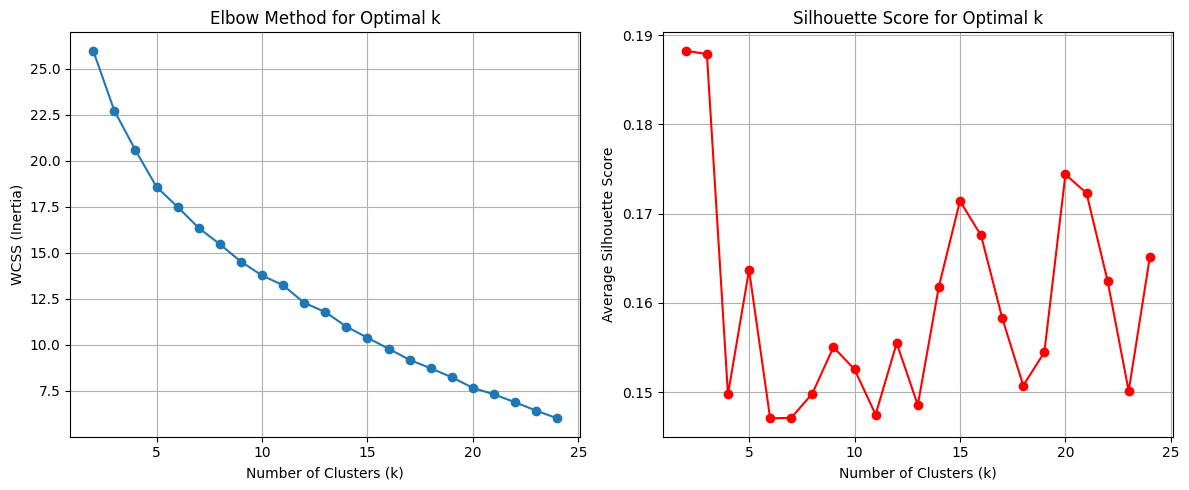

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.optimizers import Adam
from sklearn.cluster import KMeans
from scipy.optimize import minimize
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_score

# Debug: Print MultiIndex structure
print("Column MultiIndex structure:")
print("Level 0:", stocks_df_leveled.columns.levels[0].tolist())
print("Level 1:", stocks_df_leveled.columns.levels[1].tolist())
print("Sample columns:", stocks_df_leveled.columns[:10].tolist())

# Confirm (feature, ticker) order
known_features = {'Close', 'Open', 'High', 'Low', 'Volume', 'OpenInt', 'close', 'open', 'high', 'low', 'volume', 'lag_1_close', 'lag_2_close', 'RSI', 'EMA_10', 'returns', 'volatility_5'}
known_tickers = {'AAPL', 'MSFT', 'GOOG', 'ABT', 'ADBE', 'AMD', 'AMGN', 'AMZN', 'AXP', 'BAC', 'BSX', 'C', 'CAT', 'CMCSA', 'COST', 'CSCO', 'CVX', 'DHR', 'DIS', 'GE', 'GOOGL', 'GS', 'HD', 'HON', 'IBM', 'INTU', 'JNJ', 'JPM', 'KO', 'LLY', 'MCD', 'MRK', 'NVDA', 'ORCL', 'PEP', 'PFE', 'PG', 'PGR', 'QCOM', 'SMFG', 'SPGI', 'SYK', 'T', 'TMO', 'TXN', 'UNH', 'UNP', 'VZ', 'WFC', 'WMT', 'XOM'}
if any(f in stocks_df_leveled.columns.levels[0] for f in known_features):
    ticker_level = 1
    feature_level = 0
    print("Detected: Features in level 0, tickers in level 1")
else:
    ticker_level = 0
    feature_level = 1
    print("Detected: Tickers in level 0, features in level 1")

# Drop 'OpenInt' if it exists
if 'OpenInt' in stocks_df_leveled.columns.levels[feature_level]:
    stocks_df_leveled = stocks_df_leveled.drop('OpenInt', level=feature_level, axis=1)
    print("'OpenInt' dropped successfully.")
else:
    print("'OpenInt' not found in columns. Proceeding without dropping.")

# Feature engineering
def add_features(df, ticker_level=0, feature_level=1):
    tickers = [t for t in df.columns.levels[ticker_level] if t not in known_features]
    print(f"Processing tickers: {tickers[:10]}... (total: {len(tickers)})")
    for ticker in tickers:
        if ticker not in known_tickers:
            print(f"Warning: Skipping unknown ticker {ticker}")
            continue
        col = (ticker, 'Close') if ticker_level == 0 else ('Close', ticker)
        try:
            df[col]
        except KeyError:
            print(f"Warning: 'Close' not found for ticker {ticker}. Skipping.")
            continue
        df[(ticker, 'lag_1_close') if ticker_level == 0 else ('lag_1_close', ticker)] = df[col].shift(1)
        df[(ticker, 'lag_2_close') if ticker_level == 0 else ('lag_1_close', ticker)] = df[col].shift(2)
        delta = df[col].diff()
        gain = (delta.where(delta > 0, 0)).rolling(window=14).mean()
        loss = (-delta.where(delta < 0, 0)).rolling(window=14).mean()
        rs = gain / (loss + 1e-10)
        df[(ticker, 'RSI') if ticker_level == 0 else ('RSI', ticker)] = 100 - (100 / (1 + rs))
        df[(ticker, 'EMA_10') if ticker_level == 0 else ('EMA_10', ticker)] = df[col].ewm(span=10, adjust=False).mean()
        df[(ticker, 'returns') if ticker_level == 0 else ('returns', ticker)] = df[col].pct_change()
        df[(ticker, 'volatility_5') if ticker_level == 0 else ('volatility_5', ticker)] = df[(ticker, 'returns') if ticker_level == 0 else ('returns', ticker)].rolling(window=5).std()
    
    print("Feature engineering complete. Columns after:", df.columns.levels[feature_level].tolist())
    return df.dropna()

# Apply feature engineering
stocks_df_leveled = add_features(stocks_df_leveled, ticker_level=ticker_level, feature_level=feature_level)

# Correlation-Based Clustering
print("\n--- Correlation-Based Clustering ---")
tickers_for_clustering = [t for t in stocks_df_leveled.columns.levels[ticker_level] if t not in known_features]

# Select 'returns' columns
if feature_level == 0:  # Features level 0, tickers level 1
    returns_df = stocks_df_leveled.loc[:, pd.IndexSlice['returns', tickers_for_clustering]]
    returns_df.columns = returns_df.columns.droplevel(0)  # Drop 'returns'
else:  # Tickers level 0, features level 1
    returns_df = stocks_df_leveled.loc[:, pd.IndexSlice[tickers_for_clustering, 'returns']]
    returns_df.columns = returns_df.columns.droplevel(1)  # Drop 'returns'

# Calculate correlation matrix
correlation_matrix = returns_df.corr().fillna(0)

# --- New Section: Determine Optimal Number of Clusters ---
print("\n--- Determining Optimal Number of Clusters ---")
possible_k_values = range(2, 25) # Example range: Check 2 to 10 clusters
wcss = [] # Within-cluster sum of squares (for Elbow method)
silhouette_scores = [] # Average silhouette scores

print("Calculating WCSS and Silhouette Scores for k=2 to 10...")
for k in possible_k_values:
    kmeans_eval = KMeans(n_clusters=k, random_state=42, n_init=24)
    cluster_labels_eval = kmeans_eval.fit_predict(correlation_matrix)

    # Elbow Method: Inertia (WCSS)
    wcss.append(kmeans_eval.inertia_)

    # Silhouette Score
    # Ensure k > 1 for silhouette score calculation
    if k > 1:
        score = silhouette_score(correlation_matrix, cluster_labels_eval)
        silhouette_scores.append(score)
        print(f"  k={k}, WCSS={kmeans_eval.inertia_:.2f}, Silhouette Score={score:.4f}")
    else:
         print(f"  k={k}, WCSS={kmeans_eval.inertia_:.2f}")


# Plotting the results
plt.figure(figsize=(12, 5))

# Elbow Method Plot
plt.subplot(1, 2, 1)
plt.plot(possible_k_values, wcss, marker='o')
plt.title('Elbow Method for Optimal k')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('WCSS (Inertia)')
plt.grid(True)

# Silhouette Score Plot
plt.subplot(1, 2, 2)
# Adjust x-axis for silhouette scores (starts from k=2)
plt.plot(possible_k_values, silhouette_scores, marker='o', color='r')
plt.title('Silhouette Score for Optimal k')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Average Silhouette Score')
plt.grid(True)

plt.tight_layout()
plt.show()




# K-Means clustering
n_clusters = 20  # Adjustable based on needs
kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
cluster_labels = kmeans.fit_predict(correlation_matrix)

# Create groups
ticker_groups = {ticker: label for ticker, label in zip(tickers_for_clustering, cluster_labels)}
groups = {i: [] for i in range(n_clusters)}
for ticker, group_id in ticker_groups.items():
    groups[group_id].append(ticker)

print("Ticker Groups:")
for group_id, tickers_in_group in groups.items():
    print(f"  Group {group_id}: {tickers_in_group[:5]}... (Total: {len(tickers_in_group)})")

# Time-based split
total_len = len(stocks_df_leveled)
train_end = int(total_len * 0.6)
val_end = train_end + int(total_len * 0.2)

train_df = stocks_df_leveled.iloc[:train_end]
val_df = stocks_df_leveled.iloc[train_end:val_end]
test_df = stocks_df_leveled.iloc[val_end:]

# Rolling window data creation with ticker subset support
def create_rolling_window_data(df, window_size=10, target_shift=1, ticker_level=0, feature_level=1, max_window_size=15, tickers_to_use=None):
    X, y, today_closes = [], [], []
    if tickers_to_use is None:
        tickers = [t for t in df.columns.levels[ticker_level] if t not in known_features]
    else:
        tickers = tickers_to_use
    num_tickers = len(tickers)
    features = ['Open', 'High', 'Low', 'Volume', 'lag_1_close', 'lag_2_close', 'RSI', 'EMA_10', 'volatility_5']
    print(f"Creating rolling windows for {num_tickers} tickers with features: {features}")
    
    feature_cols = [col for col in df.columns if col[feature_level] in features and col[ticker_level] in tickers]
    
    for i in range(max_window_size, len(df) - target_shift - 1):
        start_idx = i - window_size
        if start_idx < 0:
            continue
        window = df[feature_cols].iloc[start_idx:i]
        X.append(window.values.flatten())
        
        next_day = df.iloc[i + target_shift]
        today = df.iloc[i]
        targets = []
        closes = []
        for ticker in tickers:
            try:
                open_col = (ticker, 'Open') if ticker_level == 0 else ('Open', ticker)
                close_col = (ticker, 'Close') if ticker_level == 0 else ('Close', ticker)
                targets.append(next_day[open_col])
                targets.append(next_day[close_col])
                closes.append(today[close_col])
            except KeyError as e:
                print(f"Warning: Skipping ticker {ticker} due to missing column {e}.")
                continue
        if len(targets) == num_tickers * 2:
            y.append(targets)
            today_closes.append(closes)
    
    X, y, today_closes = np.array(X), np.array(y), np.array(today_closes)
    print(f"Created {len(X)} windows with {len(y)} targets for window_size={window_size}")
    return X, y, today_closes, num_tickers

# Train model
def train_model(X_train_scaled, y_train, X_val_scaled, y_val, num_tickers):
    model = Sequential([
        Input(shape=(X_train_scaled.shape[1],)),
        Dense(512, activation='relu'),
        Dense(256, activation='relu'),
        Dense(num_tickers * 2)
    ])
    model.compile(optimizer='adam', loss='mse')
    model.fit(X_train_scaled, y_train, validation_data=(X_val_scaled, y_val), 
              epochs=50, batch_size=32, verbose=0)
    return model

# Evaluate window sizes
def evaluate_window_size(df, window_size, ticker_level=0, feature_level=1, max_window_size=15, tickers_to_use=None):
    X, y, today_closes, num_tickers = create_rolling_window_data(
        df, window_size=window_size, ticker_level=ticker_level, feature_level=feature_level, 
        max_window_size=max_window_size, tickers_to_use=tickers_to_use
    )
    
    if len(X) == 0 or len(y) == 0:
        print(f"Warning: No valid data for window_size={window_size}. Skipping.")
        return None, None, None, None, num_tickers, None, None, None, None, None, None, None, None
    
    total_size = len(X)
    train_size = int(0.6 * total_size)
    val_size = int(0.2 * total_size)
    
    X_train, y_train = X[:train_size], y[:train_size]
    X_val, y_val = X[train_size:train_size + val_size], y[train_size:train_size + val_size]
    X_test, y_test, today_closes_test = X[train_size + val_size:], y[train_size + val_size:], today_closes[train_size + val_size:]
    
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_val_scaled = scaler.transform(X_val)
    X_test_scaled = scaler.transform(X_test)
    
    model = train_model(X_train_scaled, y_train, X_val_scaled, y_val, num_tickers)
    
    y_val_pred = model.predict(X_val_scaled, verbose=0)
    val_mpe = np.mean((y_val - y_val_pred) / (y_val + 1e-10)) * 100
    y_test_pred = model.predict(X_test_scaled, verbose=0)
    
    return val_mpe, model, X, y, today_closes, num_tickers, X_train_scaled, X_val_scaled, X_test_scaled, y_train, y_val, y_test, y_test_pred, today_closes_test

# Group-Specific Optimal Window Ensemble with Reduced Computational Load
print("\n--- Group-Specific Optimal Window Ensemble ---")
window_range = range(1, 16)  # Limit to 1 through 15
all_group_predictions = {}
all_group_y_test = {}
all_group_today_closes = {}
group_final_mpe = {}
group_final_da = {}
all_tickers_ordered = [t for t in stocks_df_leveled.columns.levels[ticker_level] if t not in known_features]
ticker_to_index_map = {ticker: i for i, ticker in enumerate(all_tickers_ordered)}

for group_id, group_tickers in groups.items():
    print(f"\nProcessing Group {group_id} ({len(group_tickers)} tickers)...")
    if not group_tickers:
        print("Skipping empty group.")
        continue

    group_models = {}
    group_predictions_val = {}
    group_predictions_test = {}
    group_y_val_data = None
    group_y_test_data = None
    group_today_closes_test_data = None

    for window_size in window_range:
        _, model, _, _, _, num_tickers, _, X_val_scaled, X_test_scaled, _, y_val, y_test, y_test_pred, today_closes_test = evaluate_window_size(
            stocks_df_leveled, window_size, ticker_level=ticker_level, feature_level=feature_level, 
            max_window_size=max(window_range), tickers_to_use=group_tickers
        )
        if model is None:
            continue
        group_models[window_size] = model
        group_predictions_val[window_size] = model.predict(X_val_scaled, verbose=0)
        group_predictions_test[window_size] = y_test_pred
        if group_y_val_data is None:
            group_y_val_data = y_val
            group_y_test_data = y_test
            group_today_closes_test_data = today_closes_test

    if not group_models:
        print(f"Warning: No valid window sizes for Group {group_id}.")
        continue

    # Stack validation predictions for weight optimization
    val_preds = np.stack([group_predictions_val[ws] for ws in window_range if ws in group_predictions_val], axis=-1)
    y_val_true = group_y_val_data

    # Define loss function for weight optimization (MSE)
    def loss_function(weights):
        weighted_pred = np.sum(val_preds * weights[None, None, :], axis=-1)
        mse = np.mean((y_val_true - weighted_pred) ** 2)
        return mse

    # Initial weights (equal)
    initial_weights = np.ones(len(group_models)) / len(group_models)

    # Constraints: weights sum to 1, each weight >= 0
    constraints = ({'type': 'eq', 'fun': lambda w: np.sum(w) - 1})
    bounds = [(0, 1) for _ in range(len(group_models))]

    # Optimize weights
    result = minimize(loss_function, initial_weights, method='SLSQP', bounds=bounds, constraints=constraints)
    optimal_weights = result.x
    print(f"Optimal weights for Group {group_id}: {optimal_weights}")

    # Create ensemble prediction for the group
    test_preds = np.stack([group_predictions_test[ws] for ws in window_range if ws in group_predictions_test], axis=-1)
    group_ensemble_pred = np.sum(test_preds * optimal_weights[None, None, :], axis=-1)

    all_group_predictions[group_id] = group_ensemble_pred
    all_group_y_test[group_id] = group_y_test_data
    all_group_today_closes[group_id] = group_today_closes_test_data

    # Evaluate group ensemble
    group_mpe = np.mean((group_y_test_data - group_ensemble_pred) / (group_y_test_data + 1e-10)) * 100
    group_actual_close = group_y_test_data[:, 1::2]
    group_predicted_close = group_ensemble_pred[:, 1::2]
    group_last_close = group_today_closes_test_data
    group_actual_change = group_actual_close - group_last_close
    group_predicted_change = group_predicted_close - group_last_close
    group_da = np.mean(np.sign(group_actual_change) == np.sign(group_predicted_change))
    group_final_mpe[group_id] = group_mpe
    group_final_da[group_id] = group_da
    print(f"  Group {group_id} Ensemble: Test MPE = {group_mpe:.4f}%, DA = {group_da:.4f}")

# Combine Group Predictions
num_test_samples = list(all_group_predictions.values())[0].shape[0]
num_total_tickers = len(all_tickers_ordered)
final_ensemble_pred = np.zeros((num_test_samples, num_total_tickers * 2))
final_y_test = np.zeros((num_test_samples, num_total_tickers * 2))
final_today_closes = np.zeros((num_test_samples, num_total_tickers))

for group_id, group_tickers in groups.items():
    if group_id not in all_group_predictions:
        continue
    group_pred = all_group_predictions[group_id]
    group_y = all_group_y_test[group_id]
    group_closes = all_group_today_closes[group_id]
    for i, ticker in enumerate(group_tickers):
        original_idx = ticker_to_index_map[ticker]
        final_ensemble_pred[:, original_idx * 2] = group_pred[:, i * 2]
        final_ensemble_pred[:, original_idx * 2 + 1] = group_pred[:, i * 2 + 1]
        final_y_test[:, original_idx * 2] = group_y[:, i * 2]
        final_y_test[:, original_idx * 2 + 1] = group_y[:, i * 2 + 1]
        final_today_closes[:, original_idx] = group_closes[:, i]

# Evaluate Final Ensemble
final_mpe = np.mean((final_y_test - final_ensemble_pred) / (final_y_test + 1e-10)) * 100
print(f"Group-Based Ensemble Overall Test Mean Percentage Error (MPE): {final_mpe:.4f}%")

final_actual_close = final_y_test[:, 1::2]
final_predicted_close = final_ensemble_pred[:, 1::2]
final_last_close = final_today_closes
final_actual_change = final_actual_close - final_last_close
final_predicted_change = final_predicted_close - final_last_close
directional_accuracy = np.mean(np.sign(final_actual_change) == np.sign(final_predicted_change))
print(f"Group-Based Ensemble Overall Directional Accuracy for Close Prices: {directional_accuracy:.4f}")

# Check for unprocessed tickers
processed_tickers = set()
for group_tickers in groups.values():
    processed_tickers.update(group_tickers)
unprocessed_tickers = set(all_tickers_ordered) - processed_tickers
if unprocessed_tickers:
    print(f"Warning: Tickers not processed: {unprocessed_tickers}")

